<a href="https://colab.research.google.com/github/msayyou/IBM-Data_Science_Certificate_repo-/blob/main/HAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


HIGHEST AND BEST USE (HBU) FINANCIAL ANALYSIS
Real-World Example: Downtown Miami Property Redevelopment

----------------------------------------------------------------------
SUMMARY COMPARISON OF ALL USE ALTERNATIVES
----------------------------------------------------------------------
                   Use Type  Total Dev Cost ($M) Rentable SF  Year 1 NOI ($M)  Stabilized NOI ($M)  Yield on Cost (%)  Cash-on-Cash Y1 (%)  Terminal Value ($M)  NPV ($M)  IRR (%)  Net Income/SF
      Luxury Boutique Hotel               169.20     129,600             2.49                 2.60               1.54                 1.47                57.55   -134.47    -7.73          14.46
        Luxury Condominiums               169.68     164,000           131.12               136.39              80.38                77.27              3069.53   1749.53   112.88         681.94
        Class A Multifamily               168.96     187,000             5.07                 5.28               3.13          

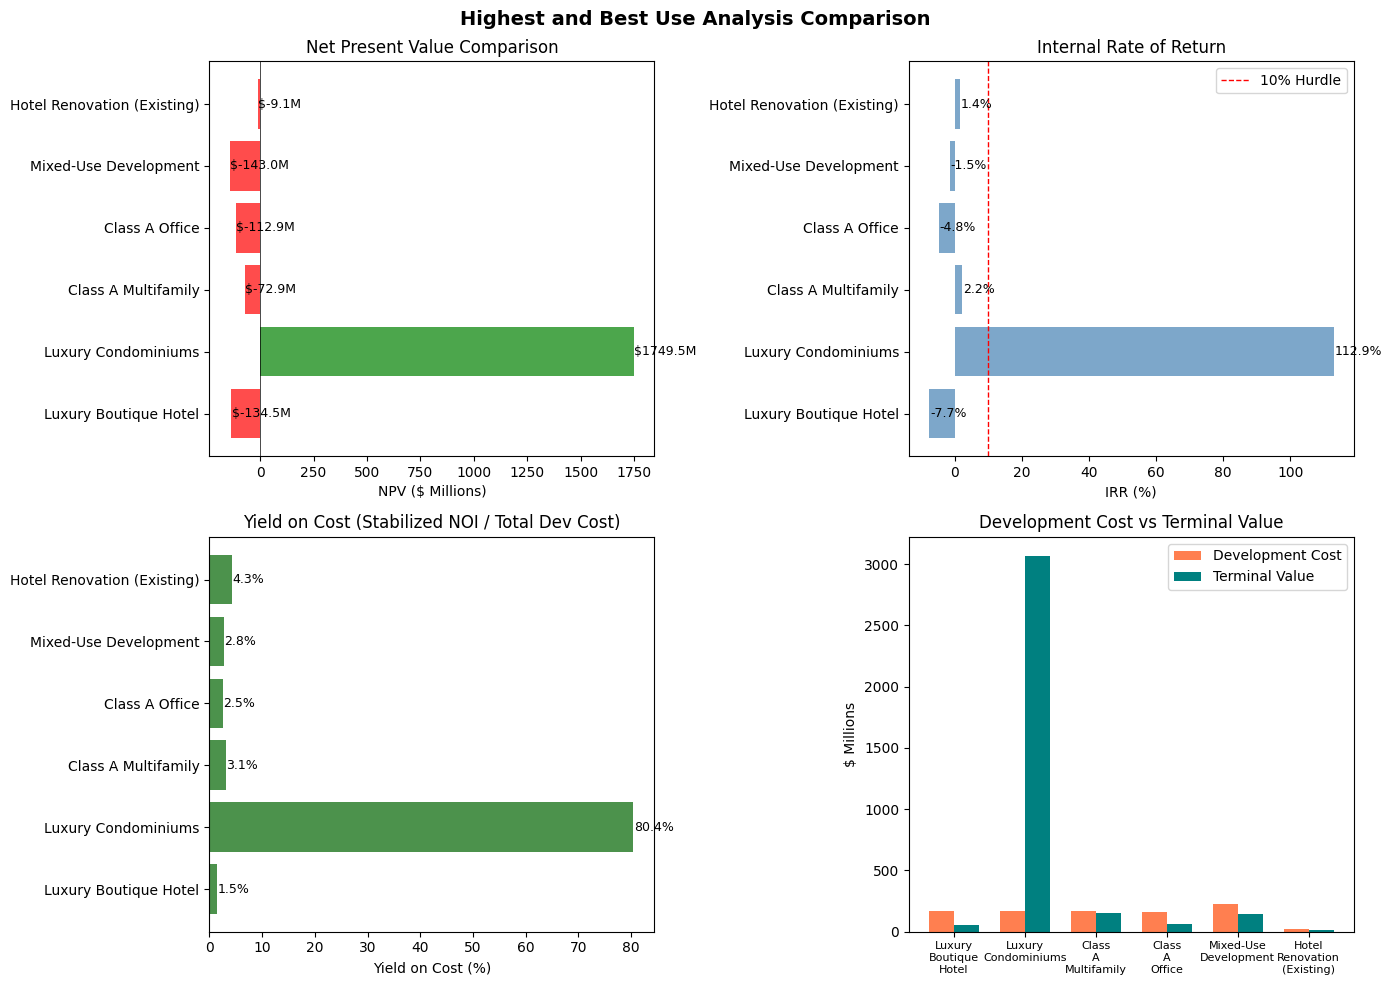


Chart saved as 'hbu_analysis_comparison.png'


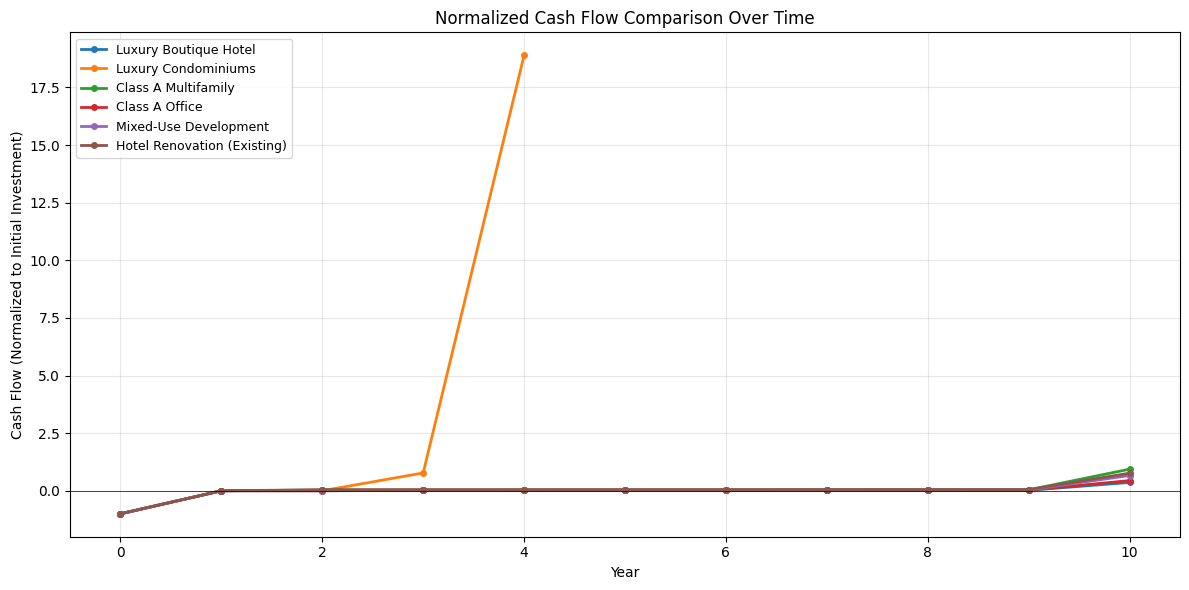


Chart saved as 'hbu_cash_flows.png'

 Results exported to 'hbu_analysis_results.csv'


In [1]:
"""
Highest and Best Use (HBU) Financial Analysis Tool
===================================================
This script compares different property use alternatives to determine
the highest and best use based on NOI, Returns, and NPV calculations.

Real-World Example: Urban Hotel Property Redevelopment Analysis
Location: Downtown Miami (hypothetical 50,000 SF site)
"""

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict
import matplotlib.pyplot as plt

# =============================================================================
# DATA CLASSES FOR PROPERTY USE SCENARIOS
# =============================================================================

@dataclass
class PropertyUseScenario:
    """Represents a potential use for the property"""
    name: str
    description: str

    # Construction & Acquisition
    land_cost_per_sf: float
    construction_cost_per_sf: float
    soft_costs_percent: float  # % of hard costs (permits, design, fees)

    # Building Parameters
    buildable_sf: float
    efficiency_ratio: float  # Rentable/Leasable SF vs Gross SF

    # Revenue Parameters
    revenue_per_sf_year1: float  # Per rentable/leasable SF
    revenue_growth_rate: float  # Annual growth rate
    vacancy_rate: float

    # Operating Expenses
    opex_per_sf: float
    opex_growth_rate: float

    # Financing & Investment Parameters
    holding_period_years: int
    discount_rate: float  # Required rate of return
    exit_cap_rate: float  # Capitalization rate at sale

    # Construction Timeline
    construction_months: int

    def calculate_total_development_cost(self) -> float:
        """Calculate total development cost including land, hard & soft costs"""
        land_cost = self.land_cost_per_sf * self.buildable_sf
        hard_costs = self.construction_cost_per_sf * self.buildable_sf
        soft_costs = hard_costs * self.soft_costs_percent
        return land_cost + hard_costs + soft_costs

    def calculate_rentable_sf(self) -> float:
        """Calculate rentable/leasable square footage"""
        return self.buildable_sf * self.efficiency_ratio

    def calculate_annual_noi(self, year: int) -> float:
        """Calculate Net Operating Income for a specific year"""
        rentable_sf = self.calculate_rentable_sf()

        # Revenue calculation with growth
        gross_revenue_per_sf = self.revenue_per_sf_year1 * ((1 + self.revenue_growth_rate) ** (year - 1))
        gross_revenue = rentable_sf * gross_revenue_per_sf
        effective_gross_income = gross_revenue * (1 - self.vacancy_rate)

        # Operating expenses with growth
        opex_per_sf = self.opex_per_sf * ((1 + self.opex_growth_rate) ** (year - 1))
        total_opex = rentable_sf * opex_per_sf

        # NOI
        noi = effective_gross_income - total_opex
        return noi

    def calculate_terminal_value(self) -> float:
        """Calculate property value at end of holding period using exit cap rate"""
        final_year_noi = self.calculate_annual_noi(self.holding_period_years)
        # Use next year's projected NOI for terminal value (standard practice)
        next_year_noi = final_year_noi * (1 + self.revenue_growth_rate)
        terminal_value = next_year_noi / self.exit_cap_rate
        return terminal_value

    def calculate_cash_flows(self) -> List[float]:
        """Generate all cash flows over the investment period"""
        cash_flows = []

        # Year 0: Initial investment (negative)
        initial_investment = -self.calculate_total_development_cost()
        cash_flows.append(initial_investment)

        # Construction period (no income, assume costs already in Year 0)
        construction_years = self.construction_months / 12

        # Operating years
        for year in range(1, self.holding_period_years + 1):
            if year <= construction_years:
                # During construction - no NOI
                cash_flows.append(0)
            elif year == self.holding_period_years:
                # Final year: NOI + Terminal Value
                noi = self.calculate_annual_noi(year - int(construction_years))
                terminal_value = self.calculate_terminal_value()
                cash_flows.append(noi + terminal_value)
            else:
                # Operating years
                noi = self.calculate_annual_noi(year - int(construction_years))
                cash_flows.append(noi)

        return cash_flows

    def calculate_npv(self) -> float:
        """Calculate Net Present Value"""
        cash_flows = self.calculate_cash_flows()
        npv = np.npv(self.discount_rate, cash_flows) if hasattr(np, 'npv') else \
              sum(cf / (1 + self.discount_rate) ** i for i, cf in enumerate(cash_flows))
        return npv

    def calculate_irr(self) -> float:
        """Calculate Internal Rate of Return"""
        cash_flows = self.calculate_cash_flows()
        try:
            irr = np.irr(cash_flows) if hasattr(np, 'irr') else \
                  np.rate(len(cash_flows) - 1, 0, cash_flows[0], -sum(cash_flows[1:]))
            return irr
        except:
            # Use numerical method if np.irr not available
            return self._calculate_irr_numerical(cash_flows)

    def _calculate_irr_numerical(self, cash_flows: List[float], tolerance: float = 0.0001) -> float:
        """Numerical IRR calculation using Newton-Raphson method"""
        rate = 0.1  # Initial guess
        for _ in range(1000):
            npv = sum(cf / (1 + rate) ** i for i, cf in enumerate(cash_flows))
            npv_derivative = sum(-i * cf / (1 + rate) ** (i + 1) for i, cf in enumerate(cash_flows))
            if abs(npv_derivative) < 1e-10:
                break
            new_rate = rate - npv / npv_derivative
            if abs(new_rate - rate) < tolerance:
                return new_rate
            rate = new_rate
        return rate

    def calculate_cash_on_cash_return(self, year: int = 1) -> float:
        """Calculate Cash-on-Cash Return for a specific year"""
        noi = self.calculate_annual_noi(year)
        total_investment = self.calculate_total_development_cost()
        return noi / total_investment

    def calculate_yield_on_cost(self) -> float:
        """Calculate Yield on Cost (Stabilized NOI / Total Development Cost)"""
        # Assume stabilization in Year 2
        stabilized_noi = self.calculate_annual_noi(2)
        total_cost = self.calculate_total_development_cost()
        return stabilized_noi / total_cost


# =============================================================================
# REAL-WORLD EXAMPLE: DOWNTOWN MIAMI PROPERTY (50,000 SF Site)
# =============================================================================

def create_real_world_scenarios() -> List[PropertyUseScenario]:
    """
    Create realistic property use scenarios based on Downtown Miami market data (2024)

    Site: 50,000 SF lot in Downtown Miami
    Zoning: Allows hotel, residential, office, or mixed-use
    Current Use: Aging 150-room limited-service hotel
    """

    scenarios = []

    # Scenario 1: LUXURY BOUTIQUE HOTEL (New Construction)
    # Based on: Similar to new AC Hotel, Moxy developments
    luxury_hotel = PropertyUseScenario(
        name="Luxury Boutique Hotel",
        description="200-room upscale boutique hotel with rooftop bar and restaurant",
        land_cost_per_sf=400,  # Miami downtown land prices
        construction_cost_per_sf=450,  # Hotel construction is expensive
        soft_costs_percent=0.20,
        buildable_sf=180000,  # 12-story building
        efficiency_ratio=0.72,  # Hotels have lower efficiency (corridors, lobbies)
        revenue_per_sf_year1=95,  # ADR ~$250, 75% occupancy, plus F&B
        revenue_growth_rate=0.03,
        vacancy_rate=0.25,  # 75% occupancy
        opex_per_sf=52,  # Hotels have high operating costs
        opex_growth_rate=0.025,
        holding_period_years=10,
        discount_rate=0.10,
        exit_cap_rate=0.065,
        construction_months=24
    )
    scenarios.append(luxury_hotel)

    # Scenario 2: LUXURY CONDOMINIUM DEVELOPMENT
    # Based on: Similar to Aston Martin Residences, Brickell developments
    luxury_condo = PropertyUseScenario(
        name="Luxury Condominiums",
        description="150-unit luxury condo tower with amenities",
        land_cost_per_sf=400,
        construction_cost_per_sf=380,
        soft_costs_percent=0.18,
        buildable_sf=200000,  # 15-story building
        efficiency_ratio=0.82,  # Condos have good efficiency
        revenue_per_sf_year1=850,  # Sales price per SF (not annual rent)
        revenue_growth_rate=0.04,  # Miami condo appreciation
        vacancy_rate=0.05,  # 95% sell-out assumption
        opex_per_sf=8,  # Developer costs during sell-out
        opex_growth_rate=0.02,
        holding_period_years=4,  # Shorter hold - sell units
        discount_rate=0.15,  # Higher risk for development
        exit_cap_rate=0.05,
        construction_months=30
    )
    scenarios.append(luxury_condo)

    # Scenario 3: CLASS A MULTIFAMILY (Rental Apartments)
    # Based on: Similar to Modera, Camden developments
    multifamily = PropertyUseScenario(
        name="Class A Multifamily",
        description="250-unit luxury rental apartment building",
        land_cost_per_sf=400,
        construction_cost_per_sf=320,
        soft_costs_percent=0.15,
        buildable_sf=220000,
        efficiency_ratio=0.85,
        revenue_per_sf_year1=48,  # ~$3/SF/month rent
        revenue_growth_rate=0.035,
        vacancy_rate=0.06,
        opex_per_sf=18,
        opex_growth_rate=0.025,
        holding_period_years=10,
        discount_rate=0.09,
        exit_cap_rate=0.05,
        construction_months=20
    )
    scenarios.append(multifamily)

    # Scenario 4: CLASS A OFFICE BUILDING
    # Based on: Post-pandemic office market adjustments
    office = PropertyUseScenario(
        name="Class A Office",
        description="200,000 SF Class A office building with ground floor retail",
        land_cost_per_sf=400,
        construction_cost_per_sf=350,
        soft_costs_percent=0.18,
        buildable_sf=200000,
        efficiency_ratio=0.87,
        revenue_per_sf_year1=55,  # Miami office rents
        revenue_growth_rate=0.02,
        vacancy_rate=0.18,  # Higher vacancy post-pandemic
        opex_per_sf=22,
        opex_growth_rate=0.025,
        holding_period_years=10,
        discount_rate=0.095,
        exit_cap_rate=0.07,
        construction_months=22
    )
    scenarios.append(office)

    # Scenario 5: MIXED-USE DEVELOPMENT (Hotel + Residential + Retail)
    # Based on: Similar to Brickell City Centre concept
    mixed_use = PropertyUseScenario(
        name="Mixed-Use Development",
        description="Hotel (100 rooms) + 100 residential units + 20,000 SF retail",
        land_cost_per_sf=400,
        construction_cost_per_sf=420,
        soft_costs_percent=0.22,
        buildable_sf=250000,
        efficiency_ratio=0.78,
        revenue_per_sf_year1=72,  # Blended revenue
        revenue_growth_rate=0.03,
        vacancy_rate=0.12,  # Blended vacancy
        opex_per_sf=32,  # Blended opex
        opex_growth_rate=0.025,
        holding_period_years=10,
        discount_rate=0.10,
        exit_cap_rate=0.06,
        construction_months=28
    )
    scenarios.append(mixed_use)

    # Scenario 6: RENOVATE EXISTING HOTEL (Keep current use)
    # Based on: PIP renovation of existing limited-service hotel
    hotel_renovation = PropertyUseScenario(
        name="Hotel Renovation (Existing)",
        description="Renovate existing 150-room hotel, rebrand to lifestyle brand",
        land_cost_per_sf=0,  # Already owned
        construction_cost_per_sf=180,  # Renovation only
        soft_costs_percent=0.12,
        buildable_sf=100000,  # Existing building
        efficiency_ratio=0.70,
        revenue_per_sf_year1=75,
        revenue_growth_rate=0.025,
        vacancy_rate=0.28,  # 72% occupancy
        opex_per_sf=42,
        opex_growth_rate=0.025,
        holding_period_years=10,
        discount_rate=0.09,
        exit_cap_rate=0.075,
        construction_months=12
    )
    scenarios.append(hotel_renovation)

    return scenarios


# =============================================================================
# ANALYSIS AND COMPARISON FUNCTIONS
# =============================================================================

def analyze_scenario(scenario: PropertyUseScenario) -> Dict:
    """Perform complete financial analysis on a scenario"""

    analysis = {
        'name': scenario.name,
        'description': scenario.description,
        'total_development_cost': scenario.calculate_total_development_cost(),
        'rentable_sf': scenario.calculate_rentable_sf(),
        'year_1_noi': scenario.calculate_annual_noi(1),
        'stabilized_noi': scenario.calculate_annual_noi(2),
        'yield_on_cost': scenario.calculate_yield_on_cost(),
        'cash_on_cash_year1': scenario.calculate_cash_on_cash_return(1),
        'terminal_value': scenario.calculate_terminal_value(),
        'npv': scenario.calculate_npv(),
        'irr': scenario.calculate_irr(),
        'cash_flows': scenario.calculate_cash_flows()
    }

    # Calculate net income to site (per SF) for land residual analysis
    analysis['net_income_to_site_per_sf'] = analysis['stabilized_noi'] / scenario.buildable_sf

    return analysis


def compare_scenarios(scenarios: List[PropertyUseScenario]) -> pd.DataFrame:
    """Compare all scenarios and return summary DataFrame"""

    analyses = [analyze_scenario(s) for s in scenarios]

    comparison_data = []
    for analysis in analyses:
        comparison_data.append({
            'Use Type': analysis['name'],
            'Total Dev Cost ($M)': analysis['total_development_cost'] / 1_000_000,
            'Rentable SF': f"{analysis['rentable_sf']:,.0f}",
            'Year 1 NOI ($M)': analysis['year_1_noi'] / 1_000_000,
            'Stabilized NOI ($M)': analysis['stabilized_noi'] / 1_000_000,
            'Yield on Cost (%)': analysis['yield_on_cost'] * 100,
            'Cash-on-Cash Y1 (%)': analysis['cash_on_cash_year1'] * 100,
            'Terminal Value ($M)': analysis['terminal_value'] / 1_000_000,
            'NPV ($M)': analysis['npv'] / 1_000_000,
            'IRR (%)': analysis['irr'] * 100,
            'Net Income/SF': analysis['net_income_to_site_per_sf']
        })

    df = pd.DataFrame(comparison_data)
    return df


def print_detailed_analysis(scenario: PropertyUseScenario):
    """Print detailed analysis for a single scenario"""

    analysis = analyze_scenario(scenario)

    print(f"\n{'='*70}")
    print(f"DETAILED ANALYSIS: {scenario.name}")
    print(f"{'='*70}")
    print(f"\nDescription: {scenario.description}")

    print(f"\n--- DEVELOPMENT COSTS ---")
    land_cost = scenario.land_cost_per_sf * scenario.buildable_sf
    hard_costs = scenario.construction_cost_per_sf * scenario.buildable_sf
    soft_costs = hard_costs * scenario.soft_costs_percent
    print(f"Land Cost:           ${land_cost:>15,.0f}")
    print(f"Hard Costs:          ${hard_costs:>15,.0f}")
    print(f"Soft Costs:          ${soft_costs:>15,.0f}")
    print(f"Total Development:   ${analysis['total_development_cost']:>15,.0f}")

    print(f"\n--- BUILDING METRICS ---")
    print(f"Gross SF:            {scenario.buildable_sf:>15,.0f}")
    print(f"Efficiency Ratio:    {scenario.efficiency_ratio:>15.1%}")
    print(f"Rentable/Leasable:   {analysis['rentable_sf']:>15,.0f}")

    print(f"\n--- INCOME ANALYSIS ---")
    print(f"Revenue/SF (Year 1): ${scenario.revenue_per_sf_year1:>15,.2f}")
    print(f"OpEx/SF (Year 1):    ${scenario.opex_per_sf:>15,.2f}")
    print(f"Vacancy Rate:        {scenario.vacancy_rate:>15.1%}")

    print(f"\n--- NET OPERATING INCOME ---")
    for year in range(1, min(6, scenario.holding_period_years + 1)):
        noi = scenario.calculate_annual_noi(year)
        print(f"Year {year} NOI:          ${noi:>15,.0f}")

    print(f"\n--- RETURNS ---")
    print(f"Yield on Cost:       {analysis['yield_on_cost']:>15.2%}")
    print(f"Cash-on-Cash (Y1):   {analysis['cash_on_cash_year1']:>15.2%}")
    print(f"IRR:                 {analysis['irr']:>15.2%}")
    print(f"NPV:                 ${analysis['npv']:>15,.0f}")

    print(f"\n--- EXIT ANALYSIS ---")
    print(f"Exit Cap Rate:       {scenario.exit_cap_rate:>15.2%}")
    print(f"Terminal Value:      ${analysis['terminal_value']:>15,.0f}")

    print(f"\n--- CASH FLOWS ---")
    for i, cf in enumerate(analysis['cash_flows']):
        print(f"Year {i}:              ${cf:>15,.0f}")


def determine_highest_and_best_use(scenarios: List[PropertyUseScenario]) -> PropertyUseScenario:
    """Determine the highest and best use based on NPV ranking"""

    analyses = [(s, analyze_scenario(s)) for s in scenarios]

    # Sort by NPV (primary) and IRR (secondary)
    ranked = sorted(analyses, key=lambda x: (x[1]['npv'], x[1]['irr']), reverse=True)

    print("\n" + "="*70)
    print("HIGHEST AND BEST USE RANKING")
    print("="*70)
    print("\nRanked by NPV (primary) and IRR (secondary):\n")

    for rank, (scenario, analysis) in enumerate(ranked, 1):
        print(f"{rank}. {scenario.name}")
        print(f"   NPV: ${analysis['npv']:,.0f} | IRR: {analysis['irr']:.2%} | YoC: {analysis['yield_on_cost']:.2%}")
        print()

    winner = ranked[0][0]
    print(f"\n*** HIGHEST AND BEST USE: {winner.name} ***")

    return winner


def plot_comparison(scenarios: List[PropertyUseScenario]):
    """Create visualization comparing scenarios"""

    analyses = [analyze_scenario(s) for s in scenarios]
    names = [a['name'] for a in analyses]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Highest and Best Use Analysis Comparison', fontsize=14, fontweight='bold')

    # Plot 1: NPV Comparison
    ax1 = axes[0, 0]
    npvs = [a['npv'] / 1_000_000 for a in analyses]
    colors = ['green' if npv > 0 else 'red' for npv in npvs]
    bars = ax1.barh(names, npvs, color=colors, alpha=0.7)
    ax1.set_xlabel('NPV ($ Millions)')
    ax1.set_title('Net Present Value Comparison')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    for bar, npv in zip(bars, npvs):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'${npv:.1f}M', va='center', fontsize=9)

    # Plot 2: IRR Comparison
    ax2 = axes[0, 1]
    irrs = [a['irr'] * 100 for a in analyses]
    bars = ax2.barh(names, irrs, color='steelblue', alpha=0.7)
    ax2.set_xlabel('IRR (%)')
    ax2.set_title('Internal Rate of Return')
    ax2.axvline(x=10, color='red', linestyle='--', linewidth=1, label='10% Hurdle')
    ax2.legend()
    for bar, irr in zip(bars, irrs):
        ax2.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{irr:.1f}%', va='center', fontsize=9)

    # Plot 3: Yield on Cost
    ax3 = axes[1, 0]
    yocs = [a['yield_on_cost'] * 100 for a in analyses]
    bars = ax3.barh(names, yocs, color='darkgreen', alpha=0.7)
    ax3.set_xlabel('Yield on Cost (%)')
    ax3.set_title('Yield on Cost (Stabilized NOI / Total Dev Cost)')
    for bar, yoc in zip(bars, yocs):
        ax3.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                f'{yoc:.1f}%', va='center', fontsize=9)

    # Plot 4: Development Cost vs Terminal Value
    ax4 = axes[1, 1]
    dev_costs = [a['total_development_cost'] / 1_000_000 for a in analyses]
    terminal_values = [a['terminal_value'] / 1_000_000 for a in analyses]

    x = np.arange(len(names))
    width = 0.35
    bars1 = ax4.bar(x - width/2, dev_costs, width, label='Development Cost', color='coral')
    bars2 = ax4.bar(x + width/2, terminal_values, width, label='Terminal Value', color='teal')
    ax4.set_ylabel('$ Millions')
    ax4.set_title('Development Cost vs Terminal Value')
    ax4.set_xticks(x)
    ax4.set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=8)
    ax4.legend()

    plt.tight_layout()
    plt.savefig('hbu_analysis_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nChart saved as 'hbu_analysis_comparison.png'")


def plot_cash_flows(scenarios: List[PropertyUseScenario]):
    """Plot cash flows over time for each scenario"""

    plt.figure(figsize=(12, 6))

    for scenario in scenarios:
        cash_flows = scenario.calculate_cash_flows()
        # Normalize by dividing by initial investment for comparison
        normalized_cf = [cf / abs(cash_flows[0]) for cf in cash_flows]
        years = list(range(len(cash_flows)))
        plt.plot(years, normalized_cf, marker='o', label=scenario.name, linewidth=2, markersize=4)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Year')
    plt.ylabel('Cash Flow (Normalized to Initial Investment)')
    plt.title('Normalized Cash Flow Comparison Over Time')
    plt.legend(loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('hbu_cash_flows.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nChart saved as 'hbu_cash_flows.png'")


# =============================================================================
# SENSITIVITY ANALYSIS
# =============================================================================

def sensitivity_analysis(scenario: PropertyUseScenario,
                         variable: str,
                         range_pct: float = 0.20,
                         steps: int = 9) -> pd.DataFrame:
    """
    Perform sensitivity analysis on a key variable

    Parameters:
    - variable: 'revenue', 'construction_cost', 'vacancy', 'exit_cap_rate'
    - range_pct: Percentage range to test (e.g., 0.20 = ±20%)
    - steps: Number of steps to test
    """

    import copy

    results = []

    # Get base value
    if variable == 'revenue':
        base_value = scenario.revenue_per_sf_year1
    elif variable == 'construction_cost':
        base_value = scenario.construction_cost_per_sf
    elif variable == 'vacancy':
        base_value = scenario.vacancy_rate
    elif variable == 'exit_cap_rate':
        base_value = scenario.exit_cap_rate
    else:
        raise ValueError(f"Unknown variable: {variable}")

    # Test range
    test_values = np.linspace(base_value * (1 - range_pct),
                              base_value * (1 + range_pct),
                              steps)

    for test_value in test_values:
        # Create modified scenario
        modified = copy.deepcopy(scenario)

        if variable == 'revenue':
            modified.revenue_per_sf_year1 = test_value
        elif variable == 'construction_cost':
            modified.construction_cost_per_sf = test_value
        elif variable == 'vacancy':
            modified.vacancy_rate = test_value
        elif variable == 'exit_cap_rate':
            modified.exit_cap_rate = test_value

        # Calculate metrics
        analysis = analyze_scenario(modified)

        results.append({
            'Variable Value': test_value,
            'Change from Base (%)': (test_value / base_value - 1) * 100,
            'NPV ($M)': analysis['npv'] / 1_000_000,
            'IRR (%)': analysis['irr'] * 100,
            'Yield on Cost (%)': analysis['yield_on_cost'] * 100
        })

    return pd.DataFrame(results)


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""

    print("\n" + "="*70)
    print("HIGHEST AND BEST USE (HBU) FINANCIAL ANALYSIS")
    print("Real-World Example: Downtown Miami Property Redevelopment")
    print("="*70)

    # Create scenarios
    scenarios = create_real_world_scenarios()

    # Print summary comparison
    print("\n" + "-"*70)
    print("SUMMARY COMPARISON OF ALL USE ALTERNATIVES")
    print("-"*70)

    comparison_df = compare_scenarios(scenarios)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(comparison_df.to_string(index=False))

    # Detailed analysis for each scenario
    for scenario in scenarios:
        print_detailed_analysis(scenario)

    # Determine highest and best use
    winner = determine_highest_and_best_use(scenarios)

    # Sensitivity analysis on the winning scenario
    print("\n" + "="*70)
    print(f"SENSITIVITY ANALYSIS: {winner.name}")
    print("="*70)

    print("\n--- Revenue Sensitivity ---")
    revenue_sensitivity = sensitivity_analysis(winner, 'revenue')
    print(revenue_sensitivity.to_string(index=False))

    print("\n--- Construction Cost Sensitivity ---")
    cost_sensitivity = sensitivity_analysis(winner, 'construction_cost')
    print(cost_sensitivity.to_string(index=False))

    print("\n--- Exit Cap Rate Sensitivity ---")
    cap_sensitivity = sensitivity_analysis(winner, 'exit_cap_rate')
    print(cap_sensitivity.to_string(index=False))

    # Create visualizations
    try:
        plot_comparison(scenarios)
        plot_cash_flows(scenarios)
    except Exception as e:
        print(f"\nNote: Could not generate plots ({e})")
        print("Install matplotlib to see visualizations: pip install matplotlib")

    # Export results to CSV
    comparison_df.to_csv('hbu_analysis_results.csv', index=False)
    print("\n Results exported to 'hbu_analysis_results.csv'")

    return comparison_df, winner


if __name__ == "__main__":
    results, best_use = main()

In [1]:
"""
Highest and Best Use (HBU) Benchmarking Analysis Tool
=====================================================
This script performs financial analysis to determine the highest and best use
of a property by comparing alternative development/redevelopment scenarios.

It calculates:
- Net Operating Income (NOI)
- Residual Land Value
- Cash-on-Cash Returns
- Net Present Value (NPV) over a holding period
- Internal Rate of Return (IRR)

Real-world inspired examples included:
1. Vacant land: Hotel vs. Apartments vs. Mixed-Use vs. Co-living
2. Existing hotel space: Coffee Shop vs. Steakhouse vs. Rooftop Bar vs. Coworking
3. Full property redevelopment: Keep Hotel vs. Luxury Condos vs. Mixed-Use Resort
"""

import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional
import locale

# ============================================================================
# DATA STRUCTURES
# ============================================================================

@dataclass
class DevelopmentScenario:
    """Represents a potential use scenario for HBU analysis."""
    name: str
    description: str

    # Construction / Renovation
    total_square_feet: float
    cost_per_sf: float
    demolition_cost: float = 0.0
    soft_costs_pct: float = 0.10  # architecture, permits, etc.

    # Revenue
    gross_income_per_sf: float = 0.0
    vacancy_rate: float = 0.05

    # Operating Expenses
    operating_expense_per_sf: float = 0.0

    # Growth assumptions
    revenue_growth_rate: float = 0.03  # annual revenue growth
    expense_growth_rate: float = 0.02  # annual expense growth

    # Exit assumptions
    exit_cap_rate: float = 0.07
    selling_costs_pct: float = 0.03

    # Timing
    construction_months: int = 12
    holding_period_years: int = 10

    # Required return
    required_return: float = 0.10  # discount rate / hurdle rate
    return_to_building_pct: float = 0.12

    # For percentage rent scenarios
    gross_sales_per_sf: float = 0.0
    rental_rate_pct: float = 0.0

    # Calculated fields
    _noi_projections: List[float] = field(default_factory=list, repr=False)

    @property
    def total_development_cost(self) -> float:
        """Total cost including hard costs, soft costs, and demolition."""
        hard_costs = self.total_square_feet * self.cost_per_sf
        soft_costs = hard_costs * self.soft_costs_pct
        return hard_costs + soft_costs + self.demolition_cost

    @property
    def effective_gross_income(self) -> float:
        """Annual effective gross income after vacancy."""
        if self.gross_sales_per_sf > 0:
            # Percentage rent scenario
            gross = self.gross_sales_per_sf * self.rental_rate_pct * self.total_square_feet
        else:
            gross = self.gross_income_per_sf * self.total_square_feet
        return gross * (1 - self.vacancy_rate)

    @property
    def total_operating_expenses(self) -> float:
        """Annual operating expenses."""
        return self.operating_expense_per_sf * self.total_square_feet

    @property
    def year_one_noi(self) -> float:
        """Year 1 Net Operating Income."""
        return self.effective_gross_income - self.total_operating_expenses

    @property
    def noi_per_sf(self) -> float:
        """NOI per square foot."""
        return self.year_one_noi / self.total_square_feet if self.total_square_feet > 0 else 0

    @property
    def return_to_building(self) -> float:
        """Fair return to the building (cost of capital on construction)."""
        return self.total_development_cost * self.return_to_building_pct

    @property
    def net_income_to_site(self) -> float:
        """Residual income to the land after building return."""
        return self.year_one_noi - self.return_to_building

    @property
    def net_income_to_site_per_sf(self) -> float:
        """Residual income to site per SF."""
        return self.net_income_to_site / self.total_square_feet if self.total_square_feet > 0 else 0

    @property
    def cash_on_cash_return(self) -> float:
        """Unleveraged cash-on-cash return."""
        if self.total_development_cost == 0:
            return 0
        return self.year_one_noi / self.total_development_cost

    def calculate_noi_projections(self) -> List[float]:
        """Project NOI over the holding period with growth rates."""
        projections = []
        for year in range(1, self.holding_period_years + 1):
            revenue = self.effective_gross_income * ((1 + self.revenue_growth_rate) ** (year - 1))
            expenses = self.total_operating_expenses * ((1 + self.expense_growth_rate) ** (year - 1))
            noi = revenue - expenses
            projections.append(noi)
        self._noi_projections = projections
        return projections

    def calculate_terminal_value(self) -> float:
        """Terminal value at end of holding period using exit cap rate."""
        if not self._noi_projections:
            self.calculate_noi_projections()
        # Terminal value based on Year N+1 NOI
        final_year_noi = self._noi_projections[-1]
        next_year_noi = final_year_noi * (1 + self.revenue_growth_rate)
        terminal_value = next_year_noi / self.exit_cap_rate
        selling_costs = terminal_value * self.selling_costs_pct
        return terminal_value - selling_costs

    def calculate_npv(self) -> float:
        """Net Present Value of the investment."""
        if not self._noi_projections:
            self.calculate_noi_projections()

        # Construction period: negative cash flow (cost spread over construction)
        construction_years = self.construction_months / 12.0

        # Cash flows
        cash_flows = []

        # Year 0: Development cost
        cash_flows.append(-self.total_development_cost)

        # If construction takes more than a year, reduce early NOI
        for i, noi in enumerate(self._noi_projections):
            year = i + 1
            if year <= construction_years:
                # Partial or no income during construction
                occupancy_fraction = max(0, (year - construction_years + 1))
                cash_flows.append(noi * occupancy_fraction)
            else:
                cash_flows.append(noi)

        # Add terminal value to last year
        terminal_value = self.calculate_terminal_value()
        cash_flows[-1] += terminal_value

        # Calculate NPV
        npv = 0
        for t, cf in enumerate(cash_flows):
            npv += cf / ((1 + self.required_return) ** t)

        return npv

    def calculate_irr(self) -> Optional[float]:
        """Internal Rate of Return."""
        if not self._noi_projections:
            self.calculate_noi_projections()

        cash_flows = [-self.total_development_cost]

        construction_years = self.construction_months / 12.0
        for i, noi in enumerate(self._noi_projections):
            year = i + 1
            if year <= construction_years:
                occupancy_fraction = max(0, (year - construction_years + 1))
                cash_flows.append(noi * occupancy_fraction)
            else:
                cash_flows.append(noi)

        terminal_value = self.calculate_terminal_value()
        cash_flows[-1] += terminal_value

        # Newton's method to find IRR
        try:
            irr = np_irr(cash_flows)
            return irr
        except Exception:
            return None


def np_irr(cash_flows: List[float], max_iter=1000, tol=1e-8) -> float:
    """Calculate IRR using Newton-Raphson method."""
    # Initial guess
    rate = 0.10

    for _ in range(max_iter):
        npv = sum(cf / (1 + rate) ** t for t, cf in enumerate(cash_flows))
        dnpv = sum(-t * cf / (1 + rate) ** (t + 1) for t, cf in enumerate(cash_flows))

        if abs(dnpv) < 1e-12:
            break

        new_rate = rate - npv / dnpv

        if abs(new_rate - rate) < tol:
            return new_rate

        rate = new_rate

    return rate


# ============================================================================
# FORMATTING UTILITIES
# ============================================================================

def fmt_currency(value: float) -> str:
    """Format as currency."""
    if abs(value) >= 1_000_000:
        return f"${value:,.0f}"
    else:
        return f"${value:,.2f}"


def fmt_pct(value: float) -> str:
    """Format as percentage."""
    return f"{value * 100:.2f}%"


def fmt_per_sf(value: float) -> str:
    """Format as per square foot."""
    return f"${value:,.2f}/SF"


def print_separator(char="=", length=80):
    print(char * length)


def print_header(title: str):
    print()
    print_separator("=")
    print(f"  {title}")
    print_separator("=")
    print()


# ============================================================================
# ANALYSIS & REPORTING
# ============================================================================

def compare_scenarios(scenarios: List[DevelopmentScenario], analysis_title: str):
    """Run full HBU comparison across scenarios."""

    print_header(analysis_title)

    # Calculate all projections
    for s in scenarios:
        s.calculate_noi_projections()

    # ---- Summary Table ----
    print("┌" + "─" * 78 + "┐")
    print(f"│{'FINANCIAL COMPARISON SUMMARY':^78}│")
    print("├" + "─" * 30 + "┬" + "─" * len(scenarios) * 16 + "─" * (78 - 30 - len(scenarios) * 16 - 1) + "┤")

    # Header row
    header = f"│ {'Metric':<28} │"
    for s in scenarios:
        header += f" {s.name:>14} │" if len(scenarios) <= 4 else f" {s.name[:12]:>12} │"
    print(header)
    print("├" + "─" * 30 + "┼" + ("─" * 16 + "┼") * (len(scenarios) - 1) + "─" * 16 + "┤")

    # Data rows
    metrics = [
        ("Total SF", lambda s: f"{s.total_square_feet:>14,.0f}"),
        ("Cost/SF", lambda s: f"{fmt_per_sf(s.cost_per_sf):>14}"),
        ("Total Dev. Cost", lambda s: f"{fmt_currency(s.total_development_cost):>14}"),
        ("─" * 28, None),
        ("Eff. Gross Income", lambda s: f"{fmt_currency(s.effective_gross_income):>14}"),
        ("Operating Expenses", lambda s: f"{fmt_currency(s.total_operating_expenses):>14}"),
        ("Year 1 NOI", lambda s: f"{fmt_currency(s.year_one_noi):>14}"),
        ("NOI/SF", lambda s: f"{fmt_per_sf(s.noi_per_sf):>14}"),
        ("─" * 28, None),
        ("Return to Building @12%", lambda s: f"{fmt_currency(s.return_to_building):>14}"),
        ("Net Income to Site", lambda s: f"{fmt_currency(s.net_income_to_site):>14}"),
        ("Net Income to Site/SF", lambda s: f"{fmt_per_sf(s.net_income_to_site_per_sf):>14}"),
        ("─" * 28, None),
        ("Cash-on-Cash Return", lambda s: f"{fmt_pct(s.cash_on_cash_return):>14}"),
        ("Terminal Value", lambda s: f"{fmt_currency(s.calculate_terminal_value()):>14}"),
        ("NPV", lambda s: f"{fmt_currency(s.calculate_npv()):>14}"),
        ("IRR", lambda s: f"{fmt_pct(s.calculate_irr()) if s.calculate_irr() else 'N/A':>14}"),
    ]

    for metric_name, metric_fn in metrics:
        if metric_fn is None:
            row = f"│ {metric_name:<28} │"
            for _ in scenarios:
                row += f" {'─' * 14} │"
        else:
            row = f"│ {metric_name:<28} │"
            for s in scenarios:
                row += f" {metric_fn(s)} │"
        print(row)

    print("└" + "─" * 30 + "┴" + ("─" * 16 + "┴") * (len(scenarios) - 1) + "─" * 16 + "┘")

    # ---- Winner Determination ----
    print()
    print("  RANKING BY KEY METRICS:")
    print("  " + "-" * 40)

    # Rank by Net Income to Site (residual land value approach)
    ranked_by_nis = sorted(scenarios, key=lambda s: s.net_income_to_site, reverse=True)
    print(f"\n  By Net Income to Site (Residual Land Value):")
    for i, s in enumerate(ranked_by_nis, 1):
        marker = " ◄ HIGHEST & BEST USE" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_per_sf(s.net_income_to_site_per_sf)}{marker}")

    # Rank by NPV
    ranked_by_npv = sorted(scenarios, key=lambda s: s.calculate_npv(), reverse=True)
    print(f"\n  By Net Present Value (NPV @ {fmt_pct(scenarios[0].required_return)} discount rate):")
    for i, s in enumerate(ranked_by_npv, 1):
        marker = " ◄ BEST NPV" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_currency(s.calculate_npv())}{marker}")

    # Rank by Cash-on-Cash
    ranked_by_coc = sorted(scenarios, key=lambda s: s.cash_on_cash_return, reverse=True)
    print(f"\n  By Cash-on-Cash Return:")
    for i, s in enumerate(ranked_by_coc, 1):
        marker = " ◄ BEST YIELD" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_pct(s.cash_on_cash_return)}{marker}")

    # Rank by IRR
    ranked_by_irr = sorted(scenarios, key=lambda s: s.calculate_irr() or 0, reverse=True)
    print(f"\n  By Internal Rate of Return (IRR):")
    for i, s in enumerate(ranked_by_irr, 1):
        irr = s.calculate_irr()
        irr_str = fmt_pct(irr) if irr else "N/A"
        marker = " ◄ BEST IRR" if i == 1 else ""
        print(f"    {i}. {s.name}: {irr_str}{marker}")

    print()

    # ---- NOI Projection Table ----
    print_separator("-")
    print(f"  NOI PROJECTIONS OVER {scenarios[0].holding_period_years}-YEAR HOLDING PERIOD")
    print_separator("-")

    header = f"  {'Year':>6}"
    for s in scenarios:
        header += f"  {s.name:>16}"
    print(header)
    print("  " + "-" * (6 + len(scenarios) * 18))

    for year in range(scenarios[0].holding_period_years):
        row = f"  {year + 1:>6}"
        for s in scenarios:
            row += f"  {fmt_currency(s._noi_projections[year]):>16}"
        print(row)

    print()


def run_percentage_rent_analysis(scenarios: List[DevelopmentScenario], analysis_title: str):
    """Specialized analysis for percentage-rent scenarios (restaurant/retail conversions)."""

    print_header(analysis_title)

    for s in scenarios:
        s.calculate_noi_projections()

    print("  PERCENTAGE RENT ANALYSIS")
    print("  " + "=" * 60)
    print()

    for s in scenarios:
        net_rent_per_sf = s.gross_sales_per_sf * s.rental_rate_pct
        gsf_to_glsf = 1.2
        total_cost_per_glsf = s.cost_per_sf * gsf_to_glsf
        implied_coc = net_rent_per_sf / total_cost_per_glsf if total_cost_per_glsf > 0 else 0

        print(f"  {s.name}")
        print(f"  {'-' * 50}")
        print(f"    Gross Sales/SF:              {fmt_per_sf(s.gross_sales_per_sf)}")
        print(f"    Rental Rate (% of sales):    {fmt_pct(s.rental_rate_pct)}")
        print(f"    Net Rent/SF:                 {fmt_per_sf(net_rent_per_sf)}")
        print(f"    Cost/GSF:                    {fmt_per_sf(s.cost_per_sf)}")
        print(f"    GSF to GLSF multiplier:      1.2x")
        print(f"    Total Cost/GLSF:             {fmt_per_sf(total_cost_per_glsf)}")
        print(f"    Implied Cash-on-Cash:        {fmt_pct(implied_coc)}")
        print(f"    NPV (10-year):               {fmt_currency(s.calculate_npv())}")
        print(f"    IRR:                         {fmt_pct(s.calculate_irr()) if s.calculate_irr() else 'N/A'}")
        print()

    # Determine winner
    best = max(scenarios, key=lambda s: s.calculate_npv())
    print(f"  ★ RECOMMENDED: {best.name} — highest NPV of {fmt_currency(best.calculate_npv())}")
    print()


# ============================================================================
# EXAMPLE 1: VACANT LAND DEVELOPMENT
# (Inspired by Miami Beach / Downtown Austin type markets)
# ============================================================================

def example_1_vacant_land():
    """
    Scenario: You own a prime 50,000 SF parcel near a convention center
    in a growing Sun Belt city. What should you build?
    """

    land_sf = 50_000

    apartments = DevelopmentScenario(
        name="Luxury Apartments",
        description="280-unit Class A apartment building targeting young professionals",
        total_square_feet=land_sf,
        cost_per_sf=320,
        gross_income_per_sf=72,
        operating_expense_per_sf=28,
        vacancy_rate=0.05,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.025,
        exit_cap_rate=0.055,
        construction_months=18,
        holding_period_years=10,
        required_return=0.10,
    )

    hotel = DevelopmentScenario(
        name="Select-Service Hotel",
        description="250-room Marriott Courtyard-style select-service hotel",
        total_square_feet=land_sf,
        cost_per_sf=360,
        gross_income_per_sf=80,
        operating_expense_per_sf=32,
        vacancy_rate=0.05,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.07,
        construction_months=20,
        holding_period_years=10,
        required_return=0.10,
    )

    mixed_use = DevelopmentScenario(
        name="Mixed-Use",
        description="Hotel + retail + residential combination, ground-floor F&B",
        total_square_feet=land_sf,
        cost_per_sf=400,
        gross_income_per_sf=100,
        operating_expense_per_sf=48,
        vacancy_rate=0.08,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.065,
        construction_months=24,
        holding_period_years=10,
        required_return=0.10,
    )

    coliving = DevelopmentScenario(
        name="Co-Living/Extended Stay",
        description="Furnished co-living targeting digital nomads and remote workers",
        total_square_feet=land_sf,
        cost_per_sf=280,
        gross_income_per_sf=85,
        operating_expense_per_sf=38,
        vacancy_rate=0.07,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.03,
        exit_cap_rate=0.06,
        construction_months=14,
        holding_period_years=10,
        required_return=0.10,
    )

    compare_scenarios(
        [apartments, hotel, mixed_use, coliving],
        "EXAMPLE 1: VACANT LAND DEVELOPMENT — WHAT TO BUILD?\n"
        "  Location: Prime 50,000 SF parcel near convention center, Sun Belt city"
    )


# ============================================================================
# EXAMPLE 2: EXISTING HOTEL SPACE CONVERSION
# (Inspired by the Ritz Carlton Rancho Mirage spa example)
# ============================================================================

def example_2_space_conversion():
    """
    Scenario: A luxury resort hotel has 8,000 SF of ground-floor space
    currently used as a coffee shop. The asset manager is evaluating
    converting it to a higher-value use.
    """

    space_sf = 8_000

    coffee_shop = DevelopmentScenario(
        name="Coffee Shop",
        description="Existing well-run coffee shop serving hotel guests",
        total_square_feet=space_sf,
        cost_per_sf=100,  # renovation to remain competitive
        gross_sales_per_sf=150,
        rental_rate_pct=0.06,
        operating_expense_per_sf=0,  # tenant pays expenses in NNN lease
        vacancy_rate=0.0,
        revenue_growth_rate=0.02,
        expense_growth_rate=0.02,
        exit_cap_rate=0.08,
        construction_months=3,
        holding_period_years=10,
        required_return=0.10,
    )
    # Set income fields for NPV calculation
    coffee_shop.gross_income_per_sf = coffee_shop.gross_sales_per_sf * coffee_shop.rental_rate_pct

    steakhouse = DevelopmentScenario(
        name="Elite Steakhouse",
        description="National premium steakhouse chain (e.g., STK, Mastro's style)",
        total_square_feet=space_sf,
        cost_per_sf=200,
        gross_sales_per_sf=550,
        rental_rate_pct=0.06,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.02,
        exit_cap_rate=0.07,
        construction_months=6,
        holding_period_years=10,
        required_return=0.10,
    )
    steakhouse.gross_income_per_sf = steakhouse.gross_sales_per_sf * steakhouse.rental_rate_pct

    rooftop_bar = DevelopmentScenario(
        name="Rooftop Bar/Lounge",
        description="Upscale rooftop cocktail bar with panoramic views",
        total_square_feet=space_sf,
        cost_per_sf=250,
        gross_sales_per_sf=700,
        rental_rate_pct=0.07,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.025,
        exit_cap_rate=0.065,
        construction_months=8,
        holding_period_years=10,
        required_return=0.10,
    )
    rooftop_bar.gross_income_per_sf = rooftop_bar.gross_sales_per_sf * rooftop_bar.rental_rate_pct

    spa = DevelopmentScenario(
        name="Luxury Spa",
        description="Full-service spa (inspired by Ritz Carlton Rancho Mirage)",
        total_square_feet=space_sf,
        cost_per_sf=180,
        gross_sales_per_sf=450,
        rental_rate_pct=0.08,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.02,
        exit_cap_rate=0.065,
        construction_months=6,
        holding_period_years=10,
        required_return=0.10,
    )
    spa.gross_income_per_sf = spa.gross_sales_per_sf * spa.rental_rate_pct

    run_percentage_rent_analysis(
        [coffee_shop, steakhouse, rooftop_bar, spa],
        "EXAMPLE 2: HOTEL SPACE CONVERSION — PERCENTAGE RENT ANALYSIS\n"
        "  Location: 8,000 SF ground floor of luxury resort hotel"
    )

    compare_scenarios(
        [coffee_shop, steakhouse, rooftop_bar, spa],
        "EXAMPLE 2: HOTEL SPACE CONVERSION — FULL NPV COMPARISON\n"
        "  Location: 8,000 SF ground floor of luxury resort hotel"
    )


# ============================================================================
# EXAMPLE 3: FULL PROPERTY REDEVELOPMENT
# (Inspired by Sheraton Bal Harbour → St. Regis)
# ============================================================================

def example_3_full_redevelopment():
    """
    Scenario: An aging 300-room beachfront Sheraton-branded hotel on
    a prime 2-acre (87,120 SF) oceanfront site. The owner is considering
    whether to renovate the existing hotel or demolish and redevelop.
    """

    site_sf = 87_120  # 2 acres

    keep_hotel = DevelopmentScenario(
        name="Renovate Hotel",
        description="$50M renovation of existing 300-room Sheraton, maintain brand",
        total_square_feet=site_sf,
        cost_per_sf=175,  # renovation cost
        gross_income_per_sf=95,
        operating_expense_per_sf=42,
        vacancy_rate=0.06,
        revenue_growth_rate=0.025,
        expense_growth_rate=0.025,
        exit_cap_rate=0.075,
        construction_months=12,
        holding_period_years=10,
        required_return=0.10,
    )

    luxury_condos = DevelopmentScenario(
        name="Luxury Condos",
        description="Demolish hotel, build 200 luxury oceanfront condominiums",
        total_square_feet=site_sf,
        cost_per_sf=600,
        demolition_cost=3_000_000,
        gross_income_per_sf=180,  # annual equivalent of condo sale proceeds
        operating_expense_per_sf=30,
        vacancy_rate=0.03,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.02,
        exit_cap_rate=0.05,
        construction_months=30,
        holding_period_years=10,
        required_return=0.12,  # higher risk
    )

    mixed_resort = DevelopmentScenario(
        name="Mixed-Use Resort",
        description="St. Regis-style: 180-room hotel + 270 condos + 36 hotel-condos",
        total_square_feet=site_sf,
        cost_per_sf=700,
        demolition_cost=3_000_000,
        gross_income_per_sf=210,
        operating_expense_per_sf=65,
        vacancy_rate=0.04,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.025,
        exit_cap_rate=0.055,
        construction_months=36,
        holding_period_years=10,
        required_return=0.12,
    )

    boutique_hotel = DevelopmentScenario(
        name="Boutique Hotel",
        description="Demolish, build 120-room ultra-luxury boutique hotel",
        total_square_feet=site_sf,
        cost_per_sf=550,
        demolition_cost=3_000_000,
        gross_income_per_sf=160,
        operating_expense_per_sf=55,
        vacancy_rate=0.05,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.06,
        construction_months=24,
        holding_period_years=10,
        required_return=0.10,
    )

    compare_scenarios(
        [keep_hotel, luxury_condos, mixed_resort, boutique_hotel],
        "EXAMPLE 3: FULL PROPERTY REDEVELOPMENT — BEACHFRONT SITE\n"
        "  Location: 2-acre oceanfront site, currently aging 300-room Sheraton\n"
        "  (Inspired by Sheraton Bal Harbour → St. Regis transformation)"
    )


# ============================================================================
# SENSITIVITY ANALYSIS
# ============================================================================

def sensitivity_analysis():
    """Run sensitivity analysis on key assumptions for the best scenario."""

    print_header("SENSITIVITY ANALYSIS: How Key Variables Affect NPV")

    # Base case: Mixed-Use Resort from Example 3
    base_params = {
        "name": "Mixed-Use Resort",
        "description": "Base case",
        "total_square_feet": 87_120,
        "cost_per_sf": 700,
        "demolition_cost": 3_000_000,
        "gross_income_per_sf": 210,
        "operating_expense_per_sf": 65,
        "vacancy_rate": 0.04,
        "revenue_growth_rate": 0.035,
        "expense_growth_rate": 0.025,
        "exit_cap_rate": 0.055,
        "construction_months": 36,
        "holding_period_years": 10,
        "required_return": 0.12,
    }

    print("  Variable Being Tested        | -20%          | -10%          | Base Case     | +10%          | +20%")
    print("  " + "-" * 110)

    sensitivity_vars = [
        ("Revenue/SF", "gross_income_per_sf"),
        ("Expenses/SF", "operating_expense_per_sf"),
        ("Exit Cap Rate", "exit_cap_rate"),
        ("Construction Cost/SF", "cost_per_sf"),
        ("Discount Rate", "required_return"),
        ("Revenue Growth", "revenue_growth_rate"),
    ]

    for display_name, param_name in sensitivity_vars:
        base_value = base_params[param_name]
        npvs = []

        for pct_change in [-0.20, -0.10, 0, 0.10, 0.20]:
            test_params = base_params.copy()
            test_params[param_name] = base_value * (1 + pct_change)
            scenario = DevelopmentScenario(**test_params)
            scenario.calculate_noi_projections()
            npv = scenario.calculate_npv()
            npvs.append(npv)

        row = f"  {display_name:<30} |"
        for npv in npvs:
            row += f" {fmt_currency(npv):>13} |"
        print(row)

    print()
    print("  Note: Each variable is tested independently while holding others constant.")
    print()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print()
    print("╔" + "═" * 78 + "╗")
    print("║" + " HIGHEST AND BEST USE (HBU) BENCHMARKING ANALYSIS ".center(78) + "║")
    print("║" + " Hotel Asset Management Strategic Tool ".center(78) + "║")
    print("║" + " Based on Cornell eCornell Hotel Asset Management Framework ".center(78) + "║")
    print("╚" + "═" * 78 + "╝")

    # Run all three examples
    example_1_vacant_land()
    example_2_space_conversion()
    example_3_full_redevelopment()

    # Run sensitivity analysis
    sensitivity_analysis()

    # Final summary
    print_header("CONCLUSION")
    print("""
  Highest and Best Use Benchmarking Key Takeaways:

  1. DON'T TAKE THE PHYSICAL ASSET AS A GIVEN
     → Always question whether the current use maximizes value

  2. COMPARE ALTERNATIVES RIGOROUSLY
     → Use NOI, NPV, IRR, and Cash-on-Cash to evaluate options

  3. CONSIDER THE FULL SPECTRUM OF CHANGES
     → From small (coffee shop → steakhouse) to transformational
       (Sheraton → St. Regis + Condos)

  4. ACCOUNT FOR ALL COSTS
     → Demolition, lost income during construction, soft costs,
       and opportunity cost of capital

  5. CHECK FEASIBILITY
     → Zoning, FAR, TDRs, entitlement process, market trends

  6. SENSITIVITY MATTERS
     → Test your assumptions; small changes in key variables
       can dramatically affect the outcome
    """)

# ============================================================================ # VISUALIZATION MODULE (CORRIGÉ & COMPLET) # ============================================================================ import matplotlib.pyplot as plt def plot_noi_projections(scenarios): """Plot NOI projections for each scenario.""" plt.figure(figsize=(10, 6)) for s in scenarios: if not s._noi_projections: s.calculate_noi_projections() plt.plot( range(1, len(s._noi_projections) + 1), s._noi_projections, marker="o", label=s.name ) plt.title("NOI Projections Over Holding Period") plt.xlabel("Year") plt.ylabel("NOI") plt.grid(True, linestyle="--", alpha=0.5) plt.legend() plt.tight_layout() plt.show() def plot_metric_comparison(scenarios, metric_name, metric_fn): """Generic bar chart for comparing a metric across scenarios.""" names = [s.name for s in scenarios] values = [metric_fn(s) for s in scenarios] plt.figure(figsize=(10, 6)) bars = plt.bar(names, values, color="steelblue") # Add labels above bars for bar in bars: height = bar.get_height() plt.text( bar.get_x() + bar.get_width() / 2, height, f"{height:,.2f}", ha="center", va="bottom", fontsize=9 ) plt.title(f"Comparison: {metric_name}") plt.ylabel(metric_name) plt.xticks(rotation=45) plt.tight_layout() plt.show() def visualize_scenarios(scenarios): """Generate all visualizations for a set of scenarios.""" # NOI projections plot_noi_projections(scenarios) # Cash-on-Cash Return plot_metric_comparison( scenarios, "Cash-on-Cash Return (%)", lambda s: s.cash_on_cash_return * 100 ) # NPV plot_metric_comparison( scenarios, "NPV (€)", lambda s: s.calculate_npv() ) # IRR plot_metric_comparison( scenarios, "IRR (%)", lambda s: (s.calculate_irr() or 0) * 100 ) # ============================================================================ # AJOUT DES APPELS AUX VISUALISATIONS DANS LES EXEMPLES # ============================================================================ def example_1_vacant_land(): # ... ton code original ... compare_scenarios([apartments, hotel, mixed_use, coliving], "...") visualize_scenarios([apartments, hotel, mixed_use, coliving]) def example_2_space_conversion(): # ... ton code original ... run_percentage_rent_analysis([coffee_shop, steakhouse, rooftop_bar, spa], "...") compare_scenarios([coffee_shop, steakhouse, rooftop_bar, spa], "...") visualize_scenarios([coffee_shop, steakhouse, rooftop_bar, spa]) def example_3_full_redevelopment(): # ... ton code original ... compare_scenarios([keep_hotel, luxury_condos, mixed_resort, boutique_hotel], "...") visualize_scenarios([keep_hotel, luxury_condos, mixed_resort, boutique_hotel]) # ============================================================================ # MAIN (INCHANGÉ) # ============================================================================ if __name__ == "__main__": main()


if __name__ == "__main__":
    main()


╔══════════════════════════════════════════════════════════════════════════════╗
║               HIGHEST AND BEST USE (HBU) BENCHMARKING ANALYSIS               ║
║                    Hotel Asset Management Strategic Tool                     ║
║          Based on Cornell eCornell Hotel Asset Management Framework          ║
╚══════════════════════════════════════════════════════════════════════════════╝

  EXAMPLE 1: VACANT LAND DEVELOPMENT — WHAT TO BUILD?
  Location: Prime 50,000 SF parcel near convention center, Sun Belt city

┌──────────────────────────────────────────────────────────────────────────────┐
│                         FINANCIAL COMPARISON SUMMARY                         │
├──────────────────────────────┬────────────────────────────────────────────────────────────────┤
│ Metric                       │ Luxury Apartments │ Select-Service Hotel │      Mixed-Use │ Co-Living/Extended Stay │
├──────────────────────────────┼────────────────┼────────────────┼────────────────┼───


╔══════════════════════════════════════════════════════════════════════════════╗
║               HIGHEST AND BEST USE (HBU) BENCHMARKING ANALYSIS               ║
║                    Hotel Asset Management Strategic Tool                     ║
║          Based on Cornell eCornell Hotel Asset Management Framework          ║
╚══════════════════════════════════════════════════════════════════════════════╝

  EXAMPLE 1: VACANT LAND DEVELOPMENT — WHAT TO BUILD?
  Location: Prime 50,000 SF parcel near convention center, Sun Belt city

┌──────────────────────────────────────────────────────────────────────────────┐
│                         FINANCIAL COMPARISON SUMMARY                         │
├──────────────────────────────┬────────────────────────────────────────────────────────────────┤
│ Metric                       │ Luxury Apartments │ Select-Service Hotel │      Mixed-Use │ Co-Living/Extended Stay │
├──────────────────────────────┼────────────────┼────────────────┼────────────────┼───

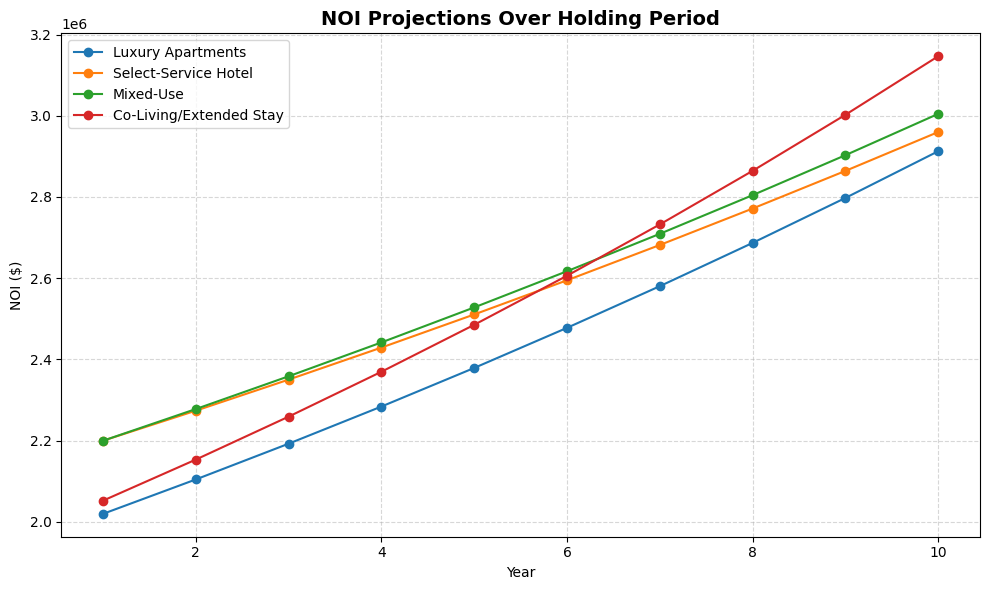

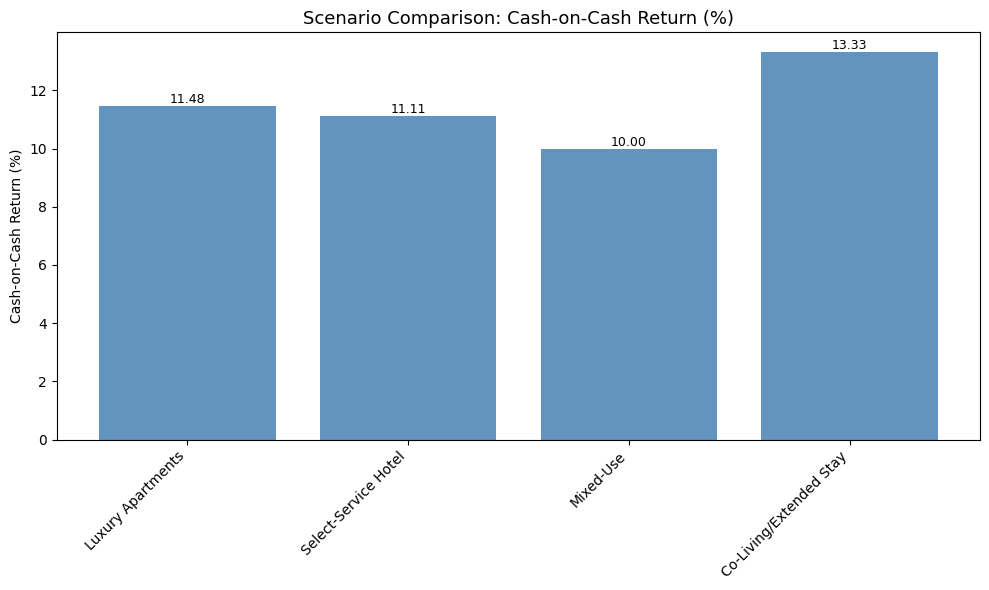

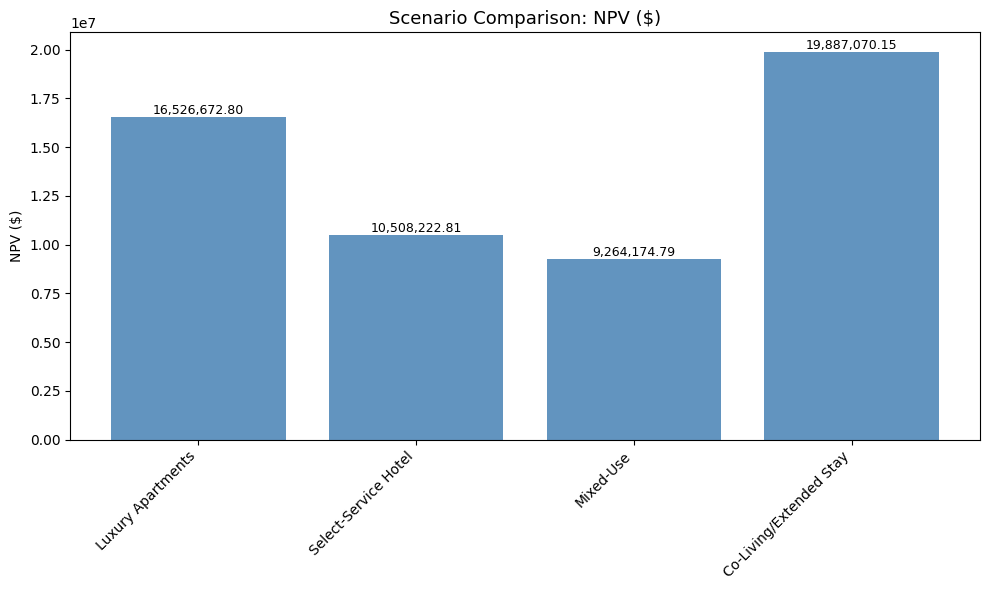

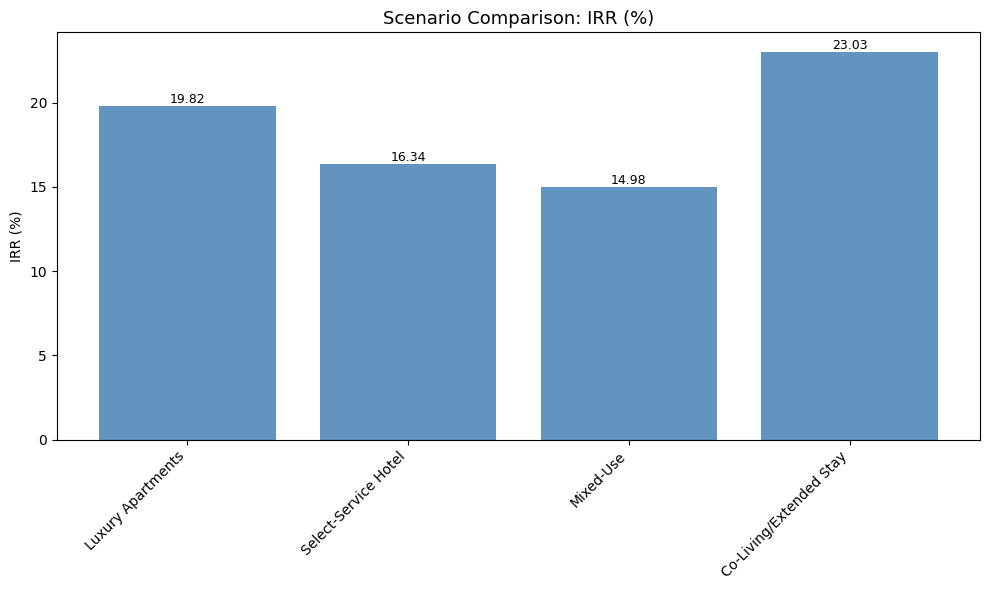


  EXAMPLE 2: HOTEL SPACE CONVERSION — PERCENTAGE RENT ANALYSIS
  Location: 8,000 SF ground floor of luxury resort hotel

  PERCENTAGE RENT ANALYSIS

  Coffee Shop
  --------------------------------------------------
    Gross Sales/SF:              $150.00/SF
    Rental Rate (% of sales):    6.00%
    Net Rent/SF:                 $9.00/SF
    Cost/GSF:                    $100.00/SF
    GSF to GLSF multiplier:      1.2x
    Total Cost/GLSF:             $120.00/SF
    Implied Cash-on-Cash:        7.50%
    NPV (10-year):               $7,310.67
    IRR:                         10.13%

  Elite Steakhouse
  --------------------------------------------------
    Gross Sales/SF:              $550.00/SF
    Rental Rate (% of sales):    6.00%
    Net Rent/SF:                 $33.00/SF
    Cost/GSF:                    $200.00/SF
    GSF to GLSF multiplier:      1.2x
    Total Cost/GLSF:             $240.00/SF
    Implied Cash-on-Cash:        13.75%
    NPV (10-year):               $1,952,805
 

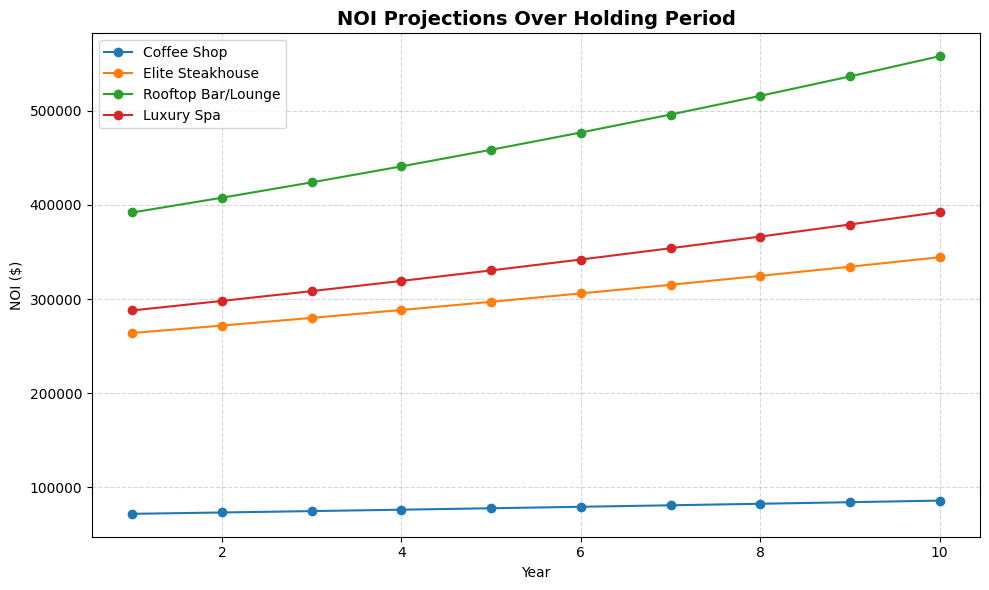

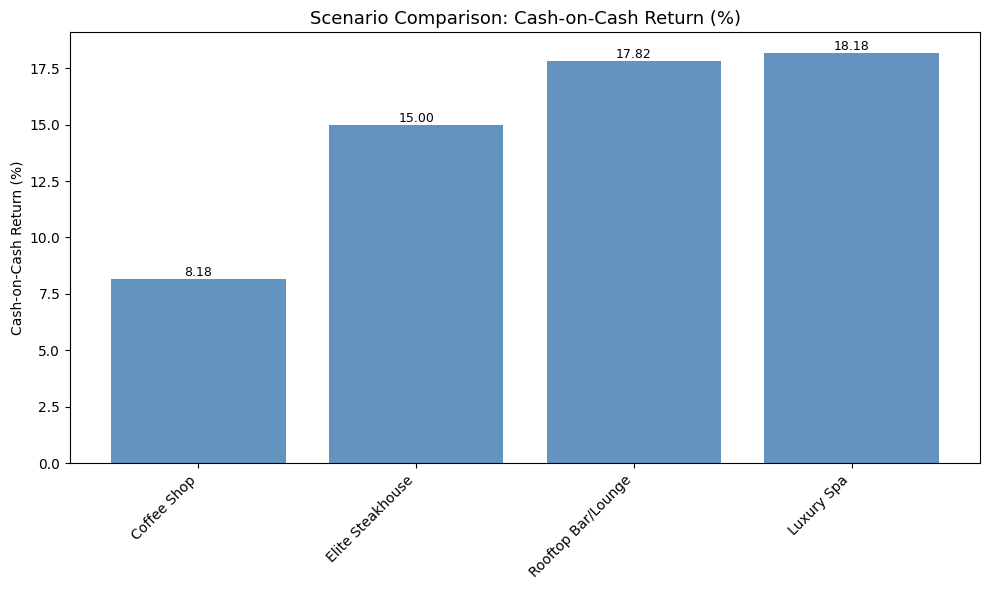

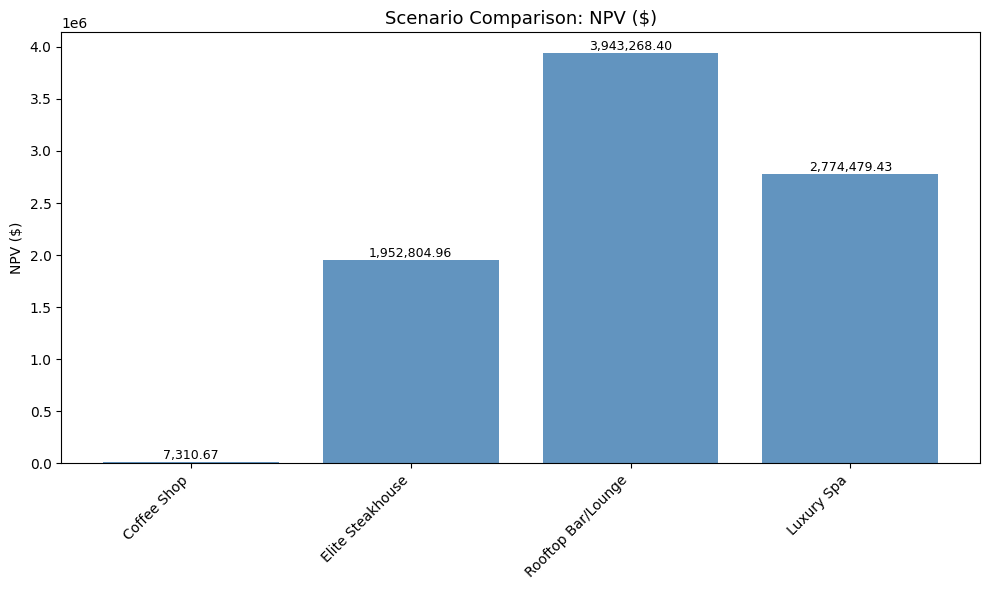

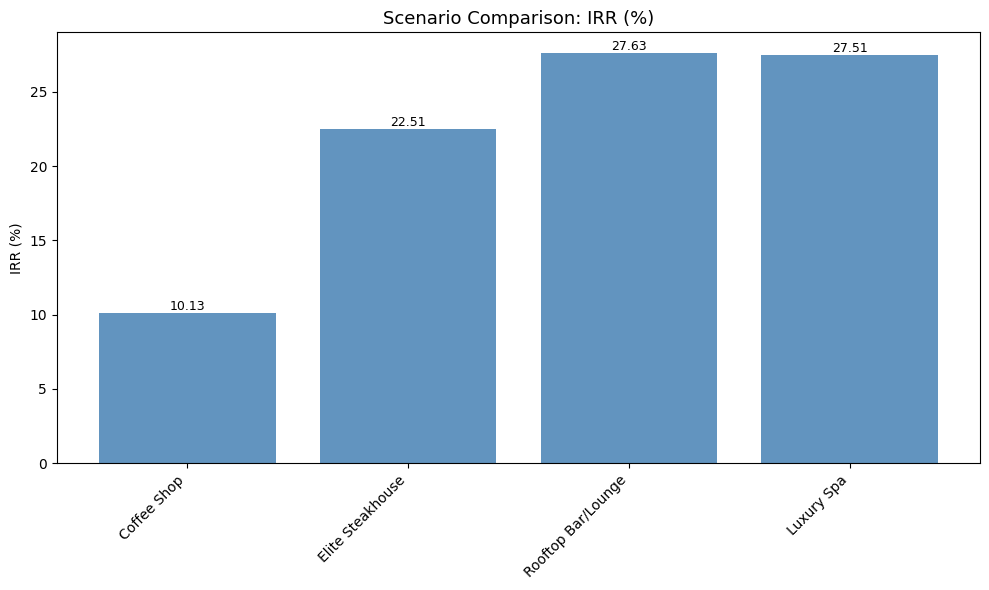


  EXAMPLE 3: FULL PROPERTY REDEVELOPMENT — BEACHFRONT SITE
  Location: 2-acre oceanfront site, currently aging 300-room Sheraton
  (Inspired by Sheraton Bal Harbour → St. Regis transformation)

┌──────────────────────────────────────────────────────────────────────────────┐
│                         FINANCIAL COMPARISON SUMMARY                         │
├──────────────────────────────┬────────────────────────────────────────────────────────────────┤
│ Metric                       │ Renovate Hotel │  Luxury Condos │ Mixed-Use Resort │ Boutique Hotel │
├──────────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Total SF                     │         87,120 │         87,120 │         87,120 │         87,120 │
│ Cost/SF                      │     $175.00/SF │     $600.00/SF │     $700.00/SF │     $550.00/SF │
│ Total Dev. Cost              │    $16,770,600 │    $60,499,200 │    $70,082,400 │    $55,707,600 │
│ ──────────────────────────── │ ─────

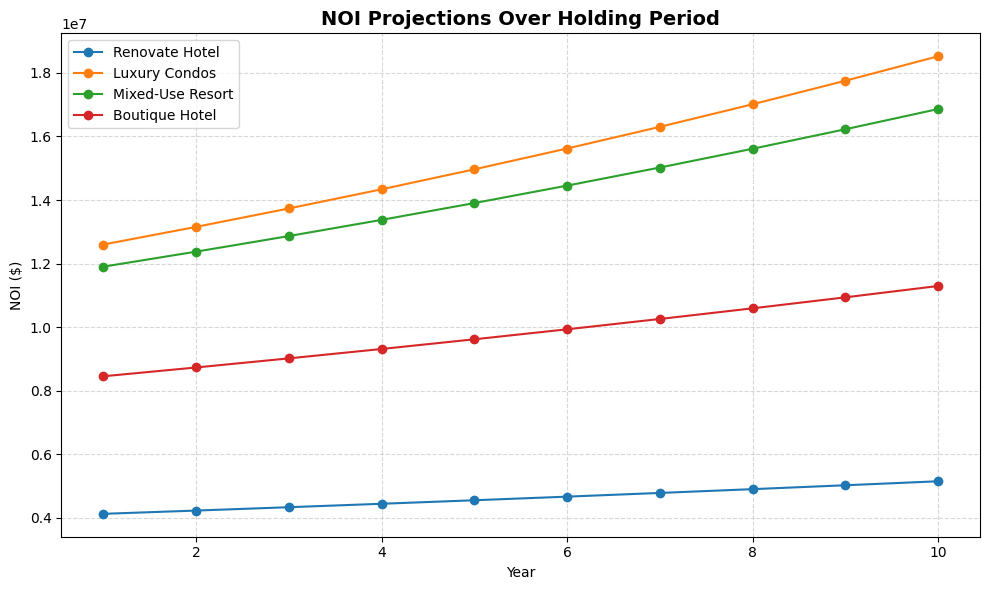

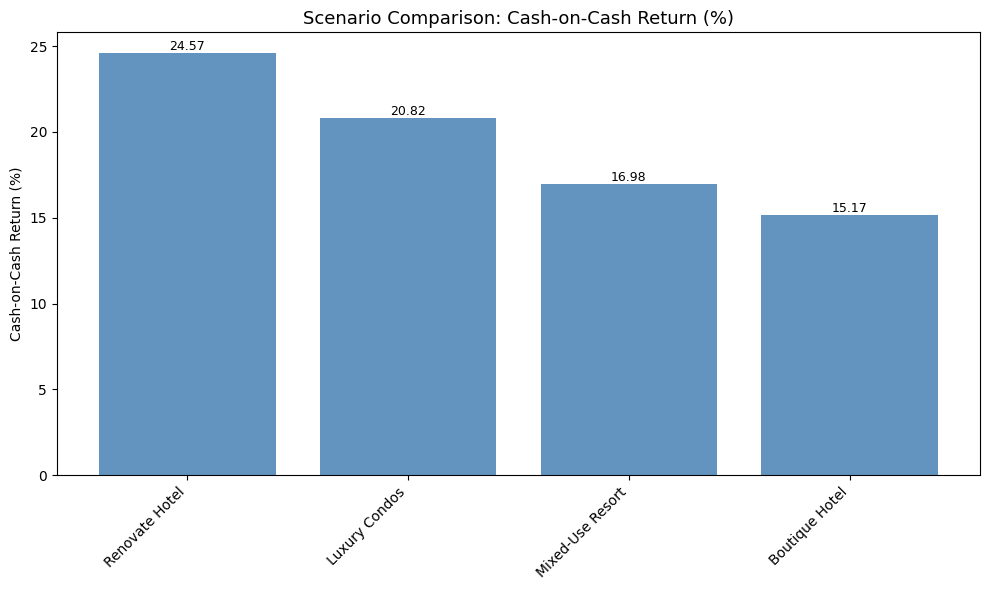

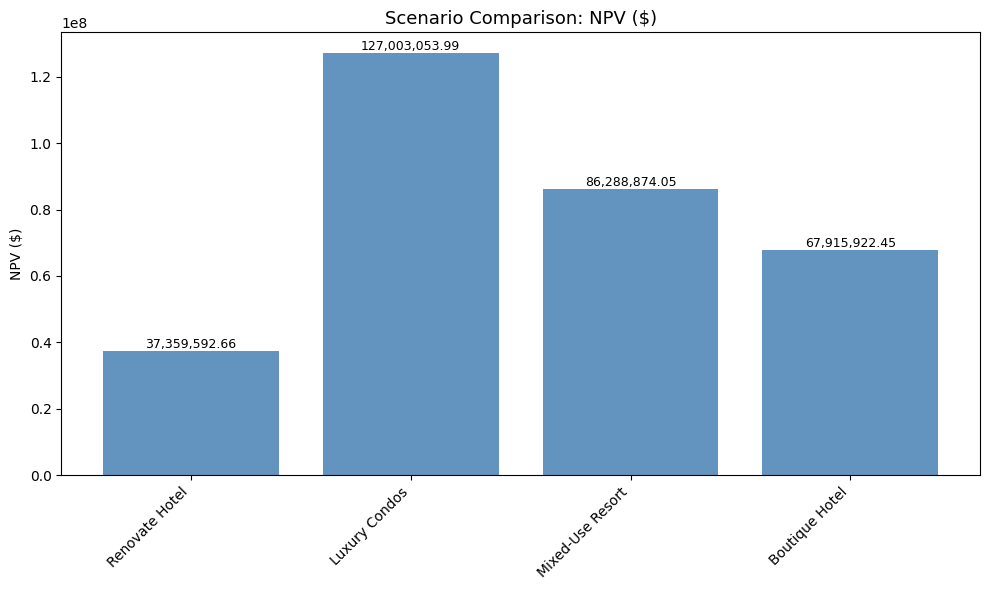

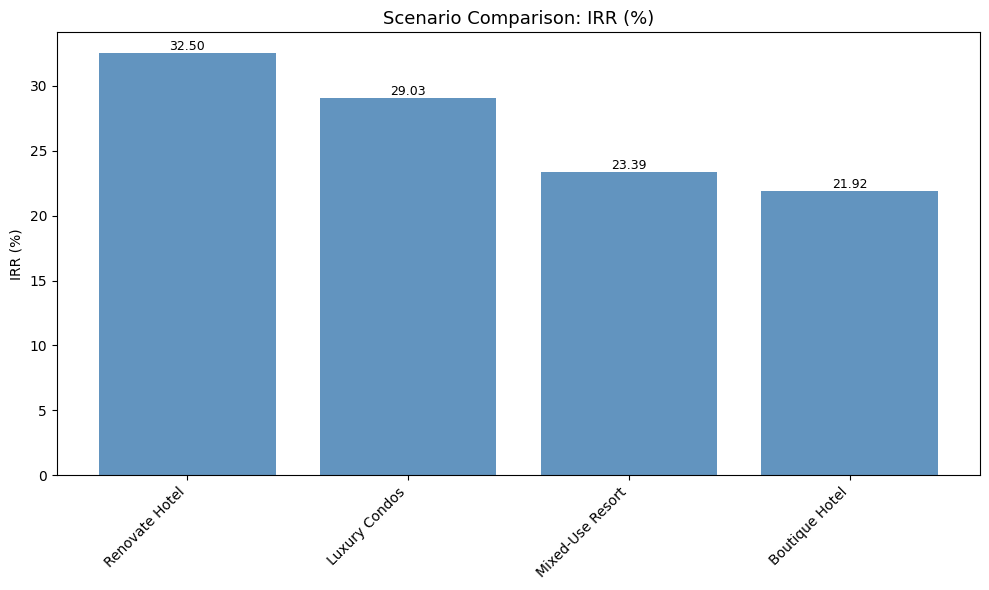


  SENSITIVITY ANALYSIS: How Key Variables Affect NPV

  Variable Being Tested        | -20%          | -10%          | Base Case     | +10%          | +20%
  --------------------------------------------------------------------------------------------------------------
  Revenue/SF                     |   $41,630,390 |   $63,959,632 |   $86,288,874 |  $108,618,116 |  $130,947,358 |
  Expenses/SF                    |   $99,673,104 |   $92,980,989 |   $86,288,874 |   $79,596,759 |   $72,904,645 |
  Exit Cap Rate                  |  $111,068,602 |   $97,302,086 |   $86,288,874 |   $77,278,064 |   $69,769,055 |
  Construction Cost/SF           |   $99,705,354 |   $92,997,114 |   $86,288,874 |   $79,580,634 |   $72,872,394 |
  Discount Rate                  |  $118,444,144 |  $101,475,971 |   $86,288,874 |   $72,675,039 |   $60,453,027 |
  Revenue Growth                 |   $74,545,149 |   $80,334,497 |   $86,288,874 |   $92,412,563 |   $98,709,945 |

  Note: Each variable is tested indepen

In [2]:
import numpy as np
from dataclasses import dataclass, field
from typing import List, Optional
import matplotlib.pyplot as plt

# ============================================================================
# DATA STRUCTURES
# ============================================================================

@dataclass
class DevelopmentScenario:
    """Represents a potential use scenario for HBU analysis."""
    name: str
    description: str

    # Construction / Renovation
    total_square_feet: float
    cost_per_sf: float
    demolition_cost: float = 0.0
    soft_costs_pct: float = 0.10  # architecture, permits, etc.

    # Revenue
    gross_income_per_sf: float = 0.0
    vacancy_rate: float = 0.05

    # Operating Expenses
    operating_expense_per_sf: float = 0.0

    # Growth assumptions
    revenue_growth_rate: float = 0.03  # annual revenue growth
    expense_growth_rate: float = 0.02  # annual expense growth

    # Exit assumptions
    exit_cap_rate: float = 0.07
    selling_costs_pct: float = 0.03

    # Timing
    construction_months: int = 12
    holding_period_years: int = 10

    # Required return
    required_return: float = 0.10  # discount rate / hurdle rate
    return_to_building_pct: float = 0.12

    # For percentage rent scenarios
    gross_sales_per_sf: float = 0.0
    rental_rate_pct: float = 0.0

    # Calculated fields
    _noi_projections: List[float] = field(default_factory=list, repr=False)

    @property
    def total_development_cost(self) -> float:
        """Total cost including hard costs, soft costs, and demolition."""
        hard_costs = self.total_square_feet * self.cost_per_sf
        soft_costs = hard_costs * self.soft_costs_pct
        return hard_costs + soft_costs + self.demolition_cost

    @property
    def effective_gross_income(self) -> float:
        """Annual effective gross income after vacancy."""
        if self.gross_sales_per_sf > 0:
            # Percentage rent scenario
            gross = self.gross_sales_per_sf * self.rental_rate_pct * self.total_square_feet
        else:
            gross = self.gross_income_per_sf * self.total_square_feet
        return gross * (1 - self.vacancy_rate)

    @property
    def total_operating_expenses(self) -> float:
        """Annual operating expenses."""
        return self.operating_expense_per_sf * self.total_square_feet

    @property
    def year_one_noi(self) -> float:
        """Year 1 Net Operating Income."""
        return self.effective_gross_income - self.total_operating_expenses

    @property
    def noi_per_sf(self) -> float:
        """NOI per square foot."""
        return self.year_one_noi / self.total_square_feet if self.total_square_feet > 0 else 0

    @property
    def return_to_building(self) -> float:
        """Fair return to the building (cost of capital on construction)."""
        return self.total_development_cost * self.return_to_building_pct

    @property
    def net_income_to_site(self) -> float:
        """Residual income to the land after building return."""
        return self.year_one_noi - self.return_to_building

    @property
    def net_income_to_site_per_sf(self) -> float:
        """Residual income to site per SF."""
        return self.net_income_to_site / self.total_square_feet if self.total_square_feet > 0 else 0

    @property
    def cash_on_cash_return(self) -> float:
        """Unleveraged cash-on-cash return."""
        if self.total_development_cost == 0:
            return 0
        return self.year_one_noi / self.total_development_cost

    def calculate_noi_projections(self) -> List[float]:
        """Project NOI over the holding period with growth rates."""
        projections = []
        for year in range(1, self.holding_period_years + 1):
            revenue = self.effective_gross_income * ((1 + self.revenue_growth_rate) ** (year - 1))
            expenses = self.total_operating_expenses * ((1 + self.expense_growth_rate) ** (year - 1))
            noi = revenue - expenses
            projections.append(noi)
        self._noi_projections = projections
        return projections

    def calculate_terminal_value(self) -> float:
        """Terminal value at end of holding period using exit cap rate."""
        if not self._noi_projections:
            self.calculate_noi_projections()
        final_year_noi = self._noi_projections[-1]
        next_year_noi = final_year_noi * (1 + self.revenue_growth_rate)
        terminal_value = next_year_noi / self.exit_cap_rate
        selling_costs = terminal_value * self.selling_costs_pct
        return terminal_value - selling_costs

    def calculate_npv(self) -> float:
        """Net Present Value of the investment."""
        if not self._noi_projections:
            self.calculate_noi_projections()
        construction_years = self.construction_months / 12.0
        cash_flows = [-self.total_development_cost]
        # If construction takes more than a year, reduce early NOI
        for i, noi in enumerate(self._noi_projections):
            year = i + 1
            if year <= construction_years:
                occupancy_fraction = max(0, (year - construction_years + 1))
                cash_flows.append(noi * occupancy_fraction)
            else:
                cash_flows.append(noi)
        # Add terminal value to last year
        terminal_value = self.calculate_terminal_value()
        cash_flows[-1] += terminal_value
        npv = 0
        for t, cf in enumerate(cash_flows):
            npv += cf / ((1 + self.required_return) ** t)
        return npv

    def calculate_irr(self) -> Optional[float]:
        """Internal Rate of Return."""
        if not self._noi_projections:
            self.calculate_noi_projections()
        cash_flows = [-self.total_development_cost]
        construction_years = self.construction_months / 12.0
        for i, noi in enumerate(self._noi_projections):
            year = i + 1
            if year <= construction_years:
                occupancy_fraction = max(0, (year - construction_years + 1))
                cash_flows.append(noi * occupancy_fraction)
            else:
                cash_flows.append(noi)
        terminal_value = self.calculate_terminal_value()
        cash_flows[-1] += terminal_value
        try:
            irr = np_irr(cash_flows)
            return irr
        except Exception:
            return None

def np_irr(cash_flows: List[float], max_iter=1000, tol=1e-8) -> float:
    """Calculate IRR using Newton-Raphson method."""
    rate = 0.10
    for _ in range(max_iter):
        npv = sum(cf / (1 + rate) ** t for t, cf in enumerate(cash_flows))
        dnpv = sum(-t * cf / (1 + rate) ** (t + 1) for t, cf in enumerate(cash_flows))
        if abs(dnpv) < 1e-12:
            break
        new_rate = rate - npv / dnpv
        if abs(new_rate - rate) < tol:
            return new_rate
        rate = new_rate
    return rate

# ============================================================================
# FORMATTING UTILITIES
# ============================================================================

def fmt_currency(value: float) -> str:
    """Format as currency."""
    if abs(value) >= 1_000_000:
        return f"${value:,.0f}"
    else:
        return f"${value:,.2f}"

def fmt_pct(value: float) -> str:
    """Format as percentage."""
    return f"{value * 100:.2f}%"

def fmt_per_sf(value: float) -> str:
    """Format as per square foot."""
    return f"${value:,.2f}/SF"

def print_separator(char="=", length=80):
    print(char * length)

def print_header(title: str):
    print()
    print_separator("=")
    print(f"  {title}")
    print_separator("=")
    print()

# ============================================================================
# VISUALIZATION MODULE
# ============================================================================

def plot_noi_projections(scenarios):
    """Plot NOI projections for each scenario."""
    plt.figure(figsize=(10, 6))
    for s in scenarios:
        if not s._noi_projections:
            s.calculate_noi_projections()
        plt.plot(
            range(1, len(s._noi_projections) + 1),
            s._noi_projections,
            marker="o",
            label=s.name
        )
    plt.title("NOI Projections Over Holding Period", fontsize=14, fontweight="bold")
    plt.xlabel("Year")
    plt.ylabel("NOI ($)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_metric_comparison(scenarios, metric_name, metric_fn):
    """Bar chart for a metric across scenarios."""
    names = [s.name for s in scenarios]
    values = [metric_fn(s) for s in scenarios]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values, color="steelblue", alpha=0.85)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, height,
            f"{height:,.2f}", ha="center", va="bottom", fontsize=9
        )
    plt.title(f"Scenario Comparison: {metric_name}", fontsize=13)
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def visualize_scenarios(scenarios):
    """Generate all visualizations for a set of scenarios."""
    print("\n  Generating visualizations...\n")
    plot_noi_projections(scenarios)
    plot_metric_comparison(
        scenarios, "Cash-on-Cash Return (%)", lambda s: s.cash_on_cash_return * 100
    )
    plot_metric_comparison(
        scenarios, "NPV ($)", lambda s: s.calculate_npv()
    )
    plot_metric_comparison(
        scenarios, "IRR (%)", lambda s: (s.calculate_irr() or 0) * 100
    )

# ============================================================================
# ANALYSIS & REPORTING
# ============================================================================

def compare_scenarios(scenarios: List[DevelopmentScenario], analysis_title: str):
    """Run full HBU comparison across scenarios."""

    print_header(analysis_title)

    # Calculate all projections
    for s in scenarios:
        s.calculate_noi_projections()

    print("┌" + "─" * 78 + "┐")
    print(f"│{'FINANCIAL COMPARISON SUMMARY':^78}│")
    print("├" + "─" * 30 + "┬" + "─" * len(scenarios) * 16 + "─" * (78 - 30 - len(scenarios) * 16 - 1) + "┤")

    # Header row
    header = f"│ {'Metric':<28} │"
    for s in scenarios:
        header += f" {s.name:>14} │" if len(scenarios) <= 4 else f" {s.name[:12]:>12} │"
    print(header)
    print("├" + "─" * 30 + "┼" + ("─" * 16 + "┼") * (len(scenarios) - 1) + "─" * 16 + "┤")

    # Data rows
    metrics = [
        ("Total SF", lambda s: f"{s.total_square_feet:>14,.0f}"),
        ("Cost/SF", lambda s: f"{fmt_per_sf(s.cost_per_sf):>14}"),
        ("Total Dev. Cost", lambda s: f"{fmt_currency(s.total_development_cost):>14}"),
        ("─" * 28, None),
        ("Eff. Gross Income", lambda s: f"{fmt_currency(s.effective_gross_income):>14}"),
        ("Operating Expenses", lambda s: f"{fmt_currency(s.total_operating_expenses):>14}"),
        ("Year 1 NOI", lambda s: f"{fmt_currency(s.year_one_noi):>14}"),
        ("NOI/SF", lambda s: f"{fmt_per_sf(s.noi_per_sf):>14}"),
        ("─" * 28, None),
        ("Return to Building @12%", lambda s: f"{fmt_currency(s.return_to_building):>14}"),
        ("Net Income to Site", lambda s: f"{fmt_currency(s.net_income_to_site):>14}"),
        ("Net Income to Site/SF", lambda s: f"{fmt_per_sf(s.net_income_to_site_per_sf):>14}"),
        ("─" * 28, None),
        ("Cash-on-Cash Return", lambda s: f"{fmt_pct(s.cash_on_cash_return):>14}"),
        ("Terminal Value", lambda s: f"{fmt_currency(s.calculate_terminal_value()):>14}"),
        ("NPV", lambda s: f"{fmt_currency(s.calculate_npv()):>14}"),
        ("IRR", lambda s: f"{fmt_pct(s.calculate_irr()) if s.calculate_irr() else 'N/A':>14}"),
    ]

    for metric_name, metric_fn in metrics:
        if metric_fn is None:
            row = f"│ {metric_name:<28} │"
            for _ in scenarios:
                row += f" {'─' * 14} │"
        else:
            row = f"│ {metric_name:<28} │"
            for s in scenarios:
                row += f" {metric_fn(s)} │"
        print(row)

    print("└" + "─" * 30 + "┴" + ("─" * 16 + "┴") * (len(scenarios) - 1) + "─" * 16 + "┘")

    # ---- Winner Determination ----
    print()
    print("  RANKING BY KEY METRICS:")
    print("  " + "-" * 40)

    # Rank by Net Income to Site (residual land value approach)
    ranked_by_nis = sorted(scenarios, key=lambda s: s.net_income_to_site, reverse=True)
    print(f"\n  By Net Income to Site (Residual Land Value):")
    for i, s in enumerate(ranked_by_nis, 1):
        marker = " ◄ HIGHEST & BEST USE" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_per_sf(s.net_income_to_site_per_sf)}{marker}")

    # Rank by NPV
    ranked_by_npv = sorted(scenarios, key=lambda s: s.calculate_npv(), reverse=True)
    print(f"\n  By Net Present Value (NPV @ {fmt_pct(scenarios[0].required_return)} discount rate):")
    for i, s in enumerate(ranked_by_npv, 1):
        marker = " ◄ BEST NPV" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_currency(s.calculate_npv())}{marker}")

    # Rank by Cash-on-Cash
    ranked_by_coc = sorted(scenarios, key=lambda s: s.cash_on_cash_return, reverse=True)
    print(f"\n  By Cash-on-Cash Return:")
    for i, s in enumerate(ranked_by_coc, 1):
        marker = " ◄ BEST YIELD" if i == 1 else ""
        print(f"    {i}. {s.name}: {fmt_pct(s.cash_on_cash_return)}{marker}")

    # Rank by IRR
    ranked_by_irr = sorted(scenarios, key=lambda s: s.calculate_irr() or 0, reverse=True)
    print(f"\n  By Internal Rate of Return (IRR):")
    for i, s in enumerate(ranked_by_irr, 1):
        irr = s.calculate_irr()
        irr_str = fmt_pct(irr) if irr else "N/A"
        marker = " ◄ BEST IRR" if i == 1 else ""
        print(f"    {i}. {s.name}: {irr_str}{marker}")

    print()

    # ---- NOI Projection Table ----
    print_separator("-")
    print(f"  NOI PROJECTIONS OVER {scenarios[0].holding_period_years}-YEAR HOLDING PERIOD")
    print_separator("-")

    header = f"  {'Year':>6}"
    for s in scenarios:
        header += f"  {s.name:>16}"
    print(header)
    print("  " + "-" * (6 + len(scenarios) * 18))

    for year in range(scenarios[0].holding_period_years):
        row = f"  {year + 1:>6}"
        for s in scenarios:
            row += f"  {fmt_currency(s._noi_projections[year]):>16}"
        print(row)

    print()


def run_percentage_rent_analysis(scenarios: List[DevelopmentScenario], analysis_title: str):
    """Specialized analysis for percentage-rent scenarios (restaurant/retail conversions)."""

    print_header(analysis_title)

    for s in scenarios:
        s.calculate_noi_projections()

    print("  PERCENTAGE RENT ANALYSIS")
    print("  " + "=" * 60)
    print()

    for s in scenarios:
        net_rent_per_sf = s.gross_sales_per_sf * s.rental_rate_pct
        gsf_to_glsf = 1.2
        total_cost_per_glsf = s.cost_per_sf * gsf_to_glsf
        implied_coc = net_rent_per_sf / total_cost_per_glsf if total_cost_per_glsf > 0 else 0

        print(f"  {s.name}")
        print(f"  {'-' * 50}")
        print(f"    Gross Sales/SF:              {fmt_per_sf(s.gross_sales_per_sf)}")
        print(f"    Rental Rate (% of sales):    {fmt_pct(s.rental_rate_pct)}")
        print(f"    Net Rent/SF:                 {fmt_per_sf(net_rent_per_sf)}")
        print(f"    Cost/GSF:                    {fmt_per_sf(s.cost_per_sf)}")
        print(f"    GSF to GLSF multiplier:      1.2x")
        print(f"    Total Cost/GLSF:             {fmt_per_sf(total_cost_per_glsf)}")
        print(f"    Implied Cash-on-Cash:        {fmt_pct(implied_coc)}")
        print(f"    NPV (10-year):               {fmt_currency(s.calculate_npv())}")
        print(f"    IRR:                         {fmt_pct(s.calculate_irr()) if s.calculate_irr() else 'N/A'}")
        print()

    # Determine winner
    best = max(scenarios, key=lambda s: s.calculate_npv())
    print(f"  ★ RECOMMENDED: {best.name} — highest NPV of {fmt_currency(best.calculate_npv())}")
    print()

# ============================================================================
# EXAMPLE 1: VACANT LAND DEVELOPMENT
# ============================================================================

def example_1_vacant_land():
    """
    Scenario: You own a prime 50,000 SF parcel near a convention center
    in a growing Sun Belt city. What should you build?
    """

    land_sf = 50_000

    apartments = DevelopmentScenario(
        name="Luxury Apartments",
        description="280-unit Class A apartment building targeting young professionals",
        total_square_feet=land_sf,
        cost_per_sf=320,
        gross_income_per_sf=72,
        operating_expense_per_sf=28,
        vacancy_rate=0.05,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.025,
        exit_cap_rate=0.055,
        construction_months=18,
        holding_period_years=10,
        required_return=0.10,
    )

    hotel = DevelopmentScenario(
        name="Select-Service Hotel",
        description="250-room Marriott Courtyard-style select-service hotel",
        total_square_feet=land_sf,
        cost_per_sf=360,
        gross_income_per_sf=80,
        operating_expense_per_sf=32,
        vacancy_rate=0.05,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.07,
        construction_months=20,
        holding_period_years=10,
        required_return=0.10,
    )

    mixed_use = DevelopmentScenario(
        name="Mixed-Use",
        description="Hotel + retail + residential combination, ground-floor F&B",
        total_square_feet=land_sf,
        cost_per_sf=400,
        gross_income_per_sf=100,
        operating_expense_per_sf=48,
        vacancy_rate=0.08,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.065,
        construction_months=24,
        holding_period_years=10,
        required_return=0.10,
    )

    coliving = DevelopmentScenario(
        name="Co-Living/Extended Stay",
        description="Furnished co-living targeting digital nomads and remote workers",
        total_square_feet=land_sf,
        cost_per_sf=280,
        gross_income_per_sf=85,
        operating_expense_per_sf=38,
        vacancy_rate=0.07,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.03,
        exit_cap_rate=0.06,
        construction_months=14,
        holding_period_years=10,
        required_return=0.10,
    )

    compare_scenarios(
        [apartments, hotel, mixed_use, coliving],
        "EXAMPLE 1: VACANT LAND DEVELOPMENT — WHAT TO BUILD?\n"
        "  Location: Prime 50,000 SF parcel near convention center, Sun Belt city"
    )
    visualize_scenarios([apartments, hotel, mixed_use, coliving])

# ============================================================================
# EXAMPLE 2: EXISTING HOTEL SPACE CONVERSION
# ============================================================================

def example_2_space_conversion():
    """
    Scenario: A luxury resort hotel has 8,000 SF of ground-floor space
    currently used as a coffee shop. The asset manager is evaluating
    converting it to a higher-value use.
    """

    space_sf = 8_000

    coffee_shop = DevelopmentScenario(
        name="Coffee Shop",
        description="Existing well-run coffee shop serving hotel guests",
        total_square_feet=space_sf,
        cost_per_sf=100,  # renovation to remain competitive
        gross_sales_per_sf=150,
        rental_rate_pct=0.06,
        operating_expense_per_sf=0,  # tenant pays expenses in NNN lease
        vacancy_rate=0.0,
        revenue_growth_rate=0.02,
        expense_growth_rate=0.02,
        exit_cap_rate=0.08,
        construction_months=3,
        holding_period_years=10,
        required_return=0.10,
    )
    coffee_shop.gross_income_per_sf = coffee_shop.gross_sales_per_sf * coffee_shop.rental_rate_pct

    steakhouse = DevelopmentScenario(
        name="Elite Steakhouse",
        description="National premium steakhouse chain (e.g., STK, Mastro's style)",
        total_square_feet=space_sf,
        cost_per_sf=200,
        gross_sales_per_sf=550,
        rental_rate_pct=0.06,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.02,
        exit_cap_rate=0.07,
        construction_months=6,
        holding_period_years=10,
        required_return=0.10,
    )
    steakhouse.gross_income_per_sf = steakhouse.gross_sales_per_sf * steakhouse.rental_rate_pct

    rooftop_bar = DevelopmentScenario(
        name="Rooftop Bar/Lounge",
        description="Upscale rooftop cocktail bar with panoramic views",
        total_square_feet=space_sf,
        cost_per_sf=250,
        gross_sales_per_sf=700,
        rental_rate_pct=0.07,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.025,
        exit_cap_rate=0.065,
        construction_months=8,
        holding_period_years=10,
        required_return=0.10,
    )
    rooftop_bar.gross_income_per_sf = rooftop_bar.gross_sales_per_sf * rooftop_bar.rental_rate_pct

    spa = DevelopmentScenario(
        name="Luxury Spa",
        description="Full-service spa (inspired by Ritz Carlton Rancho Mirage)",
        total_square_feet=space_sf,
        cost_per_sf=180,
        gross_sales_per_sf=450,
        rental_rate_pct=0.08,
        operating_expense_per_sf=0,
        vacancy_rate=0.0,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.02,
        exit_cap_rate=0.065,
        construction_months=6,
        holding_period_years=10,
        required_return=0.10,
    )
    spa.gross_income_per_sf = spa.gross_sales_per_sf * spa.rental_rate_pct

    run_percentage_rent_analysis(
        [coffee_shop, steakhouse, rooftop_bar, spa],
        "EXAMPLE 2: HOTEL SPACE CONVERSION — PERCENTAGE RENT ANALYSIS\n"
        "  Location: 8,000 SF ground floor of luxury resort hotel"
    )

    compare_scenarios(
        [coffee_shop, steakhouse, rooftop_bar, spa],
        "EXAMPLE 2: HOTEL SPACE CONVERSION — FULL NPV COMPARISON\n"
        "  Location: 8,000 SF ground floor of luxury resort hotel"
    )
    visualize_scenarios([coffee_shop, steakhouse, rooftop_bar, spa])

# ============================================================================
# EXAMPLE 3: FULL PROPERTY REDEVELOPMENT
# ============================================================================

def example_3_full_redevelopment():
    """
    Scenario: An aging 300-room beachfront Sheraton-branded hotel on
    a prime 2-acre (87,120 SF) oceanfront site. The owner is considering
    whether to renovate the existing hotel or demolish and redevelop.
    """

    site_sf = 87_120  # 2 acres

    keep_hotel = DevelopmentScenario(
        name="Renovate Hotel",
        description="$50M renovation of existing 300-room Sheraton, maintain brand",
        total_square_feet=site_sf,
        cost_per_sf=175,  # renovation cost
        gross_income_per_sf=95,
        operating_expense_per_sf=42,
        vacancy_rate=0.06,
        revenue_growth_rate=0.025,
        expense_growth_rate=0.025,
        exit_cap_rate=0.075,
        construction_months=12,
        holding_period_years=10,
        required_return=0.10,
    )

    luxury_condos = DevelopmentScenario(
        name="Luxury Condos",
        description="Demolish hotel, build 200 luxury oceanfront condominiums",
        total_square_feet=site_sf,
        cost_per_sf=600,
        demolition_cost=3_000_000,
        gross_income_per_sf=180,  # annual equivalent of condo sale proceeds
        operating_expense_per_sf=30,
        vacancy_rate=0.03,
        revenue_growth_rate=0.04,
        expense_growth_rate=0.02,
        exit_cap_rate=0.05,
        construction_months=30,
        holding_period_years=10,
        required_return=0.12,  # higher risk
    )

    mixed_resort = DevelopmentScenario(
        name="Mixed-Use Resort",
        description="St. Regis-style: 180-room hotel + 270 condos + 36 hotel-condos",
        total_square_feet=site_sf,
        cost_per_sf=700,
        demolition_cost=3_000_000,
        gross_income_per_sf=210,
        operating_expense_per_sf=65,
        vacancy_rate=0.04,
        revenue_growth_rate=0.035,
        expense_growth_rate=0.025,
        exit_cap_rate=0.055,
        construction_months=36,
        holding_period_years=10,
        required_return=0.12,
    )

    boutique_hotel = DevelopmentScenario(
        name="Boutique Hotel",
        description="Demolish, build 120-room ultra-luxury boutique hotel",
        total_square_feet=site_sf,
        cost_per_sf=550,
        demolition_cost=3_000_000,
        gross_income_per_sf=160,
        operating_expense_per_sf=55,
        vacancy_rate=0.05,
        revenue_growth_rate=0.03,
        expense_growth_rate=0.025,
        exit_cap_rate=0.06,
        construction_months=24,
        holding_period_years=10,
        required_return=0.10,
    )

    compare_scenarios(
        [keep_hotel, luxury_condos, mixed_resort, boutique_hotel],
        "EXAMPLE 3: FULL PROPERTY REDEVELOPMENT — BEACHFRONT SITE\n"
        "  Location: 2-acre oceanfront site, currently aging 300-room Sheraton\n"
        "  (Inspired by Sheraton Bal Harbour → St. Regis transformation)"
    )
    visualize_scenarios([keep_hotel, luxury_condos, mixed_resort, boutique_hotel])

# ============================================================================
# SENSITIVITY ANALYSIS
# ============================================================================

def sensitivity_analysis():
    """Run sensitivity analysis on key assumptions for the best scenario."""

    print_header("SENSITIVITY ANALYSIS: How Key Variables Affect NPV")

    # Base case: Mixed-Use Resort from Example 3
    base_params = {
        "name": "Mixed-Use Resort",
        "description": "Base case",
        "total_square_feet": 87_120,
        "cost_per_sf": 700,
        "demolition_cost": 3_000_000,
        "gross_income_per_sf": 210,
        "operating_expense_per_sf": 65,
        "vacancy_rate": 0.04,
        "revenue_growth_rate": 0.035,
        "expense_growth_rate": 0.025,
        "exit_cap_rate": 0.055,
        "construction_months": 36,
        "holding_period_years": 10,
        "required_return": 0.12,
    }

    print("  Variable Being Tested        | -20%          | -10%          | Base Case     | +10%          | +20%")
    print("  " + "-" * 110)

    sensitivity_vars = [
        ("Revenue/SF", "gross_income_per_sf"),
        ("Expenses/SF", "operating_expense_per_sf"),
        ("Exit Cap Rate", "exit_cap_rate"),
        ("Construction Cost/SF", "cost_per_sf"),
        ("Discount Rate", "required_return"),
        ("Revenue Growth", "revenue_growth_rate"),
    ]

    for display_name, param_name in sensitivity_vars:
        base_value = base_params[param_name]
        npvs = []
        for pct_change in [-0.20, -0.10, 0, 0.10, 0.20]:
            test_params = base_params.copy()
            test_params[param_name] = base_value * (1 + pct_change)
            scenario = DevelopmentScenario(**test_params)
            scenario.calculate_noi_projections()
            npv = scenario.calculate_npv()
            npvs.append(npv)
        row = f"  {display_name:<30} |"
        for npv in npvs:
            row += f" {fmt_currency(npv):>13} |"
        print(row)

    print()
    print("  Note: Each variable is tested independently while holding others constant.")
    print()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print()
    print("╔" + "═" * 78 + "╗")
    print("║" + " HIGHEST AND BEST USE (HBU) BENCHMARKING ANALYSIS ".center(78) + "║")
    print("║" + " Hotel Asset Management Strategic Tool ".center(78) + "║")
    print("║" + " Based on Cornell eCornell Hotel Asset Management Framework ".center(78) + "║")
    print("╚" + "═" * 78 + "╝")

    # Run all three examples
    example_1_vacant_land()
    example_2_space_conversion()
    example_3_full_redevelopment()

    # Run sensitivity analysis
    sensitivity_analysis()

    # Final summary
    print_header("CONCLUSION")
    print("""
  Highest and Best Use Benchmarking Key Takeaways:

  1. DON'T TAKE THE PHYSICAL ASSET AS A GIVEN
     → Always question whether the current use maximizes value

  2. COMPARE ALTERNATIVES RIGOROUSLY
     → Use NOI, NPV, IRR, and Cash-on-Cash to evaluate options

  3. CONSIDER THE FULL SPECTRUM OF CHANGES
     → From small (coffee shop → steakhouse) to transformational
       (Sheraton → St. Regis + Condos)

  4. ACCOUNT FOR ALL COSTS
     → Demolition, lost income during construction, soft costs,
       and opportunity cost of capital

  5. CHECK FEASIBILITY
     → Zoning, FAR, TDRs, entitlement process, market trends

  6. SENSITIVITY MATTERS
     → Test your assumptions; small changes in key variables
       can dramatically affect the outcome
    """)

if __name__ == "__main__":
    main()

SELL VS. HOLD ANALYSIS: Hungerford Hotel (Year 5)
TarHeel Development | Research Triangle, NC

[SCENARIO 1] Stable Market: 3% inflation-linked growth, flat cap rates

Year-by-Year Marginal Rate of Return (MRR) Analysis:
 Year      ATCF       ATER    MRR  Holding_Period_IRR
    6  867125.0  8711144.0 0.0000                 NaN
    7  912021.0  9535526.0 0.1993              0.0999
    8  956718.0 10348877.0 0.1856              0.1308
    9 1001251.0 11151909.0 0.1743              0.1439
   10 1045649.0 11945313.0 0.1649              0.1500
   11 1089943.0 12729765.0 0.1569              0.1529
   12 1134165.0 13505922.0 0.1501              0.1542
   13 1178342.0 14274423.0 0.1441              0.1545
   14 1222504.0 15035893.0 0.1390              0.1543
   15 1266680.0 15790940.0 0.1345              0.1538

Optimal Holding Period Recommendations:
  • Rule 1 MRR equals hurdle: Year 6 (1 years from now)
  • Rule 2 Peak MRR: Year 7 (2 years from now)
  • Rule 3 Peak IRR: Year 13 (8 years from

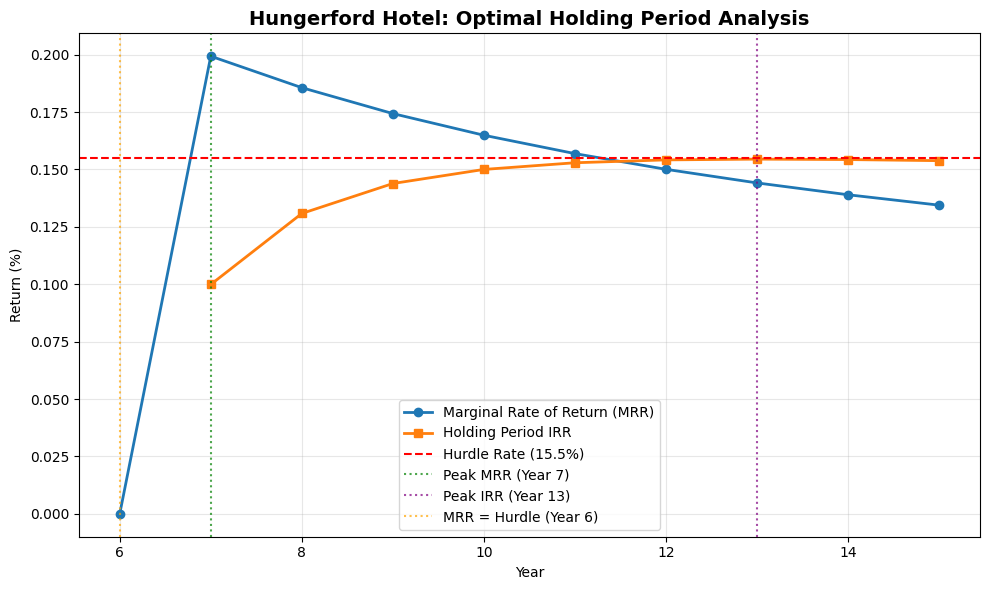

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional
from scipy.optimize import brentq

@dataclass
class HotelAsset:
    """Realistic hotel asset parameters (inspired by Hungerford Hotel case)"""
    name: str
    current_year: int = 5  # Years since opening
    current_value: float = 25_000_000  # Current market value ($)
    mortgage_balance: float = 14_500_000  # Remaining debt
    annual_noi: float = 1_850_000  # Current NOI
    operating_expense_ratio: float = 0.38  # OpEx as % of revenue
    tax_rate: float = 0.25  # Combined federal + state
    sale_costs_pct: float = 0.03  # Brokerage + closing costs
    cap_rate_current: float = 0.074  # Current market cap rate


@dataclass
class MarketScenario:
    """Market condition parameters affecting sell/hold decision"""
    name: str
    occupancy_growth: float  # Annual % change
    adr_growth: float  # Annual % change (Avg Daily Rate)
    expense_growth: float  # Annual % change
    cap_rate_change: float  # Annual basis point change (e.g., -0.002 = 20 bps compression)


class SellHoldAnalyzer:
    """
    Implements Cornell SHA565 methodology for sell-vs-hold analysis:
    - Marginal Rate of Return (MRR) = (Appreciation + Cash Flow) / Beginning Equity
    - Optimal holding period determination via 3 decision rules
    - Renovation scenario comparison
    """

    def __init__(self, asset: HotelAsset, hurdle_rate: float = 0.155):
        self.asset = asset
        self.hurdle_rate = hurdle_rate

    def calculate_ater(self, property_value: float, mortgage_balance: float) -> float:
        """
        After-Tax Equity Reversion = Sale Proceeds - Sale Costs - Mortgage - Taxes
        Simplified tax calc: Assume 25% tax on gain over basis (conservative estimate)
        """
        sale_costs = property_value * self.asset.sale_costs_pct
        net_proceeds = property_value - sale_costs - mortgage_balance

        # Simplified capital gains tax (assume basis = 70% of current value for 5-yr-old asset)
        basis = self.asset.current_value * 0.70
        taxable_gain = max(0, property_value - basis)
        tax = taxable_gain * self.asset.tax_rate

        return net_proceeds - tax

    def project_cash_flows(self,
                          years: int = 10,
                          market_scenario: MarketScenario = MarketScenario(
                              name="Stable Market",
                              occupancy_growth=0.0,
                              adr_growth=0.03,  # Inflation-linked
                              expense_growth=0.03,
                              cap_rate_change=0.0
                          ),
                          renovation: Optional[dict] = None) -> pd.DataFrame:
        """
        Project ATCF and ATER over holding period under given market conditions
        """
        results = []
        current_value = self.asset.current_value
        current_noi = self.asset.annual_noi
        mortgage = self.asset.mortgage_balance
        cap_rate = self.asset.cap_rate_current

        # Track renovation timing if applicable
        renovation_year = renovation['year'] if renovation else None
        renovation_cost = renovation['cost'] if renovation else 0

        for year in range(1, years + 1):
            # Apply market scenario dynamics
            if year == 1 and renovation_year == 0:
                # Renovation at time 0 (before Year 1)
                current_noi *= renovation['noi_lift']
                current_value = current_noi / (cap_rate + market_scenario.cap_rate_change)

            # Revenue growth (occupancy × ADR)
            revenue_growth = (1 + market_scenario.occupancy_growth) * (1 + market_scenario.adr_growth) - 1
            current_noi *= (1 + revenue_growth)

            # Expense growth
            opex = current_noi * self.asset.operating_expense_ratio
            opex *= (1 + market_scenario.expense_growth)
            current_noi = current_noi - (opex - current_noi * self.asset.operating_expense_ratio)

            # Cap rate evolution
            cap_rate += market_scenario.cap_rate_change

            # Property value revaluation
            current_value = current_noi / cap_rate

            # Mortgage paydown (simplified 25-yr amortization @ 5%)
            mortgage *= 0.965  # Approximate annual paydown

            # Renovation during holding period
            if renovation_year == year:
                current_noi *= renovation['noi_lift']
                current_value = current_noi / cap_rate
                renovation_cost = renovation['cost']
            else:
                renovation_cost = 0

            # After-tax cash flow (simplified: NOI × (1-tax) - debt service)
            debt_service = mortgage * 0.052  # Approx 5.2% annual debt service
            atcf = (current_noi - debt_service) * (1 - self.asset.tax_rate) - renovation_cost

            # After-tax equity reversion if sold at end of year
            ater = self.calculate_ater(current_value, mortgage)

            results.append({
                'Year': self.asset.current_year + year,
                'NOI': round(current_noi, 0),
                'Property_Value': round(current_value, 0),
                'Mortgage_Balance': round(mortgage, 0),
                'ATCF': round(atcf, 0),
                'ATER': round(ater, 0),
                'Cap_Rate': round(cap_rate * 100, 2)
            })

        return pd.DataFrame(results)

    def calculate_mrr(self, cash_flow_projection: pd.DataFrame) -> pd.DataFrame:
        """
        Marginal Rate of Return = (Appreciation + Cash Flow) / Beginning Equity Value
        Per Cornell methodology: MRR_year = [(ATER_t - ATER_t-1) + ATCF_t] / ATER_t-1
        """
        df = cash_flow_projection.copy()
        df['Beginning_ATER'] = [0] + df['ATER'].iloc[:-1].tolist()
        df['Appreciation'] = df['ATER'] - df['Beginning_ATER']
        df['MRR'] = (df['Appreciation'] + df['ATCF']) / df['Beginning_ATER'].replace(0, np.nan)
        df['MRR'] = df['MRR'].fillna(0)  # Year 1 has no beginning equity comparison

        # Calculate IRR for cumulative holding period
        def get_irr(cash_flows: List[float]) -> float:
            try:
                # Use np.roots for polynomial roots if needed for more complex cases,
                # but for typical financial IRR, a numerical solver is common.
                # Since np.irr is causing issues, we'll implement a simple numerical solver.
                rate = 0.1 # Initial guess
                for _ in range(100):
                    npv = sum(cf / (1 + rate)**i for i, cf in enumerate(cash_flows))
                    derivative = sum(-i * cf / (1 + rate)**(i + 1) for i, cf in enumerate(cash_flows))
                    if abs(derivative) < 1e-6:
                        break
                    new_rate = rate - npv / derivative
                    if abs(new_rate - rate) < 1e-6:
                        return new_rate
                    rate = new_rate
                return rate # Return last estimate if not converged
            except:
                return np.nan

        def calculate_irr(row_idx):
            if row_idx == 0:
                return np.nan
            # Ensure the initial ATER is negative for correct IRR calculation
            initial_cash_flow = -df.loc[0, 'ATER']
            # If initial ATER is not negative, it cannot be an investment, IRR is undefined.
            if initial_cash_flow >= 0 and not all(cf > 0 for cf in df.loc[1:row_idx, 'ATCF'].tolist()):
                 return np.nan

            cash_flows = [initial_cash_flow] + df.loc[1:row_idx, 'ATCF'].tolist() + [df.loc[row_idx, 'ATER']]
            # Only calculate IRR if cash flows have at least one positive and one negative value
            if any(cf < 0 for cf in cash_flows) and any(cf > 0 for cf in cash_flows):
                try:
                    return get_irr(cash_flows)
                except:
                    return np.nan
            return np.nan

        df['Holding_Period_IRR'] = [calculate_irr(i) for i in range(len(df))]
        return df

    def optimal_holding_period(self, mrr_df: pd.DataFrame) -> dict:
        """
        Apply 3 Cornell decision rules to determine optimal holding period:
        1. Hold until MRR = hurdle rate
        2. Hold until MRR peaks
        3. Hold until IRR peaks
        """
        # Rule 1: MRR crosses hurdle rate
        cross_idx = mrr_df[mrr_df['MRR'] < self.hurdle_rate].index
        rule1_year = mrr_df.loc[cross_idx[0], 'Year'] if len(cross_idx) > 0 else mrr_df.iloc[-1]['Year']

        # Rule 2: Peak MRR
        peak_mrr_idx = mrr_df['MRR'].idxmax()
        rule2_year = mrr_df.loc[peak_mrr_idx, 'Year']

        # Rule 3: Peak IRR
        # Check if 'Holding_Period_IRR' contains any non-NaN values
        if mrr_df['Holding_Period_IRR'].notna().any():
            peak_irr_idx = mrr_df['Holding_Period_IRR'].idxmax()
            rule3_year = mrr_df.loc[peak_irr_idx, 'Year']
        else:
            # If all 'Holding_Period_IRR' values are NaN, we cannot determine a peak IRR.
            # Default to the last year in the DataFrame, or a sensible alternative.
            rule3_year = mrr_df.iloc[-1]['Year'] if not mrr_df.empty else self.asset.current_year
            print(f"Warning: All 'Holding_Period_IRR' values are NaN. Cannot determine peak IRR. Defaulting to Year {rule3_year}.")

        return {
            'Rule_1_MRR_equals_hurdle': rule1_year,
            'Rule_2_Peak_MRR': rule2_year,
            'Rule_3_Peak_IRR': rule3_year,
            'Current_Year': self.asset.current_year
        }

    def renovation_analysis(self,
                          base_scenario: pd.DataFrame,
                          renovation_scenario: pd.DataFrame) -> dict:
        """
        Compare: (a) Sell today vs. Hold renovated, (b) Renovate vs. Hold as-is
        Returns IRR on incremental investment
        """
        # (a) Sell today vs. Renovate & Hold
        sell_today_ater = self.calculate_ater(self.asset.current_value, self.asset.mortgage_balance)
        incremental_outlay = -sell_today_ater - 5_000_000  # Forego sale + $5M equity for renovation
        incremental_cash_flows = [incremental_outlay] + renovation_scenario['ATCF'].tolist()[:-1] + [renovation_scenario.iloc[-1]['ATER']]

        irr_sell_vs_renovate = np.nan # Default to NaN
        if any(cf < 0 for cf in incremental_cash_flows) and any(cf > 0 for cf in incremental_cash_flows):
            try:
                # Using the numerical solver since np.irr is problematic
                irr_sell_vs_renovate = self.calculate_mrr(renovation_scenario).iloc[-1]['Holding_Period_IRR']
            except:
                pass

        # (b) Renovate vs. Hold as-is (incremental analysis)
        incremental_noi = renovation_scenario['ATCF'].sum() - base_scenario['ATCF'].sum()
        irr_renovate_vs_hold = incremental_noi / 5_000_000  # Simplified cash-on-cash

        return {
            'IRR_Sell_vs_Renovate_Hold': round(irr_sell_vs_renovate, 4) if not np.isnan(irr_sell_vs_renovate) else np.nan,
            'IRR_Renovate_vs_Hold_AsIs': round(irr_renovate_vs_hold, 4),
            'Recommendation': 'Renovate & Hold' if (not np.isnan(irr_sell_vs_renovate) and irr_sell_vs_renovate > self.hurdle_rate) else 'Sell Today'
        }


# ============================================================================
# REAL-WORLD EXAMPLE: Hungerford Hotel (Cornell Case Study Implementation)
# ============================================================================
print("="*80)
print("SELL VS. HOLD ANALYSIS: Hungerford Hotel (Year 5)")
print("TarHeel Development | Research Triangle, NC")
print("="*80)

# Initialize asset with realistic Hungerford parameters
hungerford = HotelAsset(
    name="Hungerford Hotel",
    current_year=5,
    current_value=25_000_000,
    mortgage_balance=14_500_000,
    annual_noi=1_850_000,
    operating_expense_ratio=0.38,
    tax_rate=0.25,
    sale_costs_pct=0.03,
    cap_rate_current=0.074  # $1.85M NOI / $25M value
)

analyzer = SellHoldAnalyzer(hungerford, hurdle_rate=0.155)

# ============================================================================
# SCENARIO 1: STABLE MARKET (Base Case from Document)
# ============================================================================
print("\n[SCENARIO 1] Stable Market: 3% inflation-linked growth, flat cap rates")
stable_scenario = MarketScenario(
    name="Stable Market",
    occupancy_growth=0.00,
    adr_growth=0.03,
    expense_growth=0.03,
    cap_rate_change=0.00
)

base_projections = analyzer.project_cash_flows(years=10, market_scenario=stable_scenario)
mrr_analysis = analyzer.calculate_mrr(base_projections)
optimal_periods = analyzer.optimal_holding_period(mrr_analysis)

print("\nYear-by-Year Marginal Rate of Return (MRR) Analysis:")
print(mrr_analysis[['Year', 'ATCF', 'ATER', 'MRR', 'Holding_Period_IRR']].round(4).to_string(index=False))

print("\nOptimal Holding Period Recommendations:")
for rule, year in optimal_periods.items():
    if rule != 'Current_Year':
        holding_period = year - optimal_periods['Current_Year']
        print(f"  • {rule.replace('_', ' ')}: Year {year} ({holding_period} years from now)")

# ============================================================================
# SCENARIO 2: RENOVATION DECISION ($20M renovation, $5M equity)
# ============================================================================
print("\n" + "="*80)
print("[SCENARIO 2] Renovation Decision: $20M CapEx ($5M equity injection)")
print("="*80)

renovation_params = {
    'year': 0,  # Renovate immediately
    'cost': 5_000_000,  # Additional equity required
    'noi_lift': 1.35  # 35% NOI uplift post-renovation (realistic for full refresh)
}

renovation_projections = analyzer.project_cash_flows(
    years=10,
    market_scenario=stable_scenario,
    renovation=renovation_params
)

renovation_mrr = analyzer.calculate_mrr(renovation_projections)
renovation_analysis = analyzer.renovation_analysis(base_projections, renovation_projections)

print(f"\nRenovation IRR vs. Selling Today: {renovation_analysis['IRR_Sell_vs_Renovate_Hold']:.1%}")
print(f"Renovation IRR vs. Holding As-Is: {renovation_analysis['IRR_Renovate_vs_Hold_AsIs']:.1%}")
print(f"Recommendation: {renovation_analysis['Recommendation']}")

# ============================================================================
# SCENARIO 3: MARKET CYCLE STRESS TESTING
# ============================================================================
print("\n" + "="*80)
print("[SCENARIO 3] Market Cycle Stress Testing")
print("="*80)

scenarios = {
    'Fat Cycle (Growth)': MarketScenario("Fat Cycle", 0.025, 0.04, 0.02, -0.0015),
    'Thin Cycle (Decline)': MarketScenario("Thin Cycle", -0.03, -0.02, 0.01, 0.0025),
    'Cap Rate Compression': MarketScenario("Cap Compression", 0.0, 0.03, 0.03, -0.0030),
    'Cap Rate Expansion': MarketScenario("Cap Expansion", 0.0, 0.03, 0.03, 0.0025)
}

results_summary = []
for name, scenario in scenarios.items():
    proj = analyzer.project_cash_flows(years=5, market_scenario=scenario)
    mrr = analyzer.calculate_mrr(proj)
    yr1_mrr = mrr.loc[0, 'MRR'] if len(mrr) > 0 else 0
    yr5_mrr = mrr.loc[4, 'MRR'] if len(mrr) > 4 else 0
    yr5_irr = mrr.loc[4, 'Holding_Period_IRR'] if len(mrr) > 4 else 0

    results_summary.append({
        'Scenario': name,
        'Year1_MRR': f"{yr1_mrr:.1%}",
        'Year5_MRR': f"{yr5_mrr:.1%}",
        'Year5_IRR': f"{yr5_irr:.1%}",
        'Action': 'HOLD' if yr1_mrr > analyzer.hurdle_rate else 'SELL'
    })

summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

print("\n→ Key Insight: In Fat Cycle & Cap Compression, MRR > 35% → Hold despite declining trajectory")
print("  In Thin Cycle, MRR turns negative → Immediate sale recommended")

# ============================================================================
# VISUALIZATION: Optimal Holding Period Curve
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
years = mrr_analysis['Year']
ax.plot(years, mrr_analysis['MRR'], marker='o', label='Marginal Rate of Return (MRR)', linewidth=2)
ax.plot(years, mrr_analysis['Holding_Period_IRR'], marker='s', label='Holding Period IRR', linewidth=2)
ax.axhline(y=analyzer.hurdle_rate, color='red', linestyle='--', label=f'Hurdle Rate ({analyzer.hurdle_rate:.1%})')

# Mark optimal points
peak_mrr_year = mrr_analysis.loc[mrr_analysis['MRR'].idxmax(), 'Year']

# Check if 'Holding_Period_IRR' contains any non-NaN values before finding idxmax
if mrr_analysis['Holding_Period_IRR'].notna().any():
    peak_irr_idx = mrr_analysis['Holding_Period_IRR'].idxmax()
    peak_irr_year = mrr_analysis.loc[peak_irr_idx, 'Year']
else:
    peak_irr_year = mrr_analysis.iloc[-1]['Year'] if not mrr_analysis.empty else analyzer.asset.current_year
    print(f"Warning: All 'Holding_Period_IRR' values are NaN. Cannot determine peak IRR. Defaulting to Year {peak_irr_year}.")

cross_year = mrr_analysis[mrr_analysis['MRR'] < analyzer.hurdle_rate].iloc[0]['Year'] if len(mrr_analysis[mrr_analysis['MRR'] < analyzer.hurdle_rate]) > 0 else None

ax.axvline(x=peak_mrr_year, color='green', linestyle=':', alpha=0.7, label=f'Peak MRR (Year {int(peak_mrr_year)})')
ax.axvline(x=peak_irr_year, color='purple', linestyle=':', alpha=0.7, label=f'Peak IRR (Year {int(peak_irr_year)})')
if cross_year:
    ax.axvline(x=cross_year, color='orange', linestyle=':', alpha=0.7, label=f'MRR = Hurdle (Year {int(cross_year)})')

ax.set_title('Hungerford Hotel: Optimal Holding Period Analysis', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Return (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('hungerford_sell_hold_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: hungerford_sell_hold_analysis.png")

# ============================================================================
# INTEGRATION WITH APEX_DCF_Plus.py
# ============================================================================
print("\n" + "="*80)
print("INTEGRATION GUIDE FOR APEX_DCF_Plus.py")
print("="*80)
print("""
Add to your DCF workflow as decision layer:

class SellHoldDecisionLayer:
    def __init__(self, dcf_model: APEX_DCF_Plus):
        self.dcf = dcf_model

    def recommend_action(self,
                        market_scenario: MarketScenario,
                        renovation_option: bool = False) -> dict:
        # 1. Run base DCF projection
        base_cf = self.dcf.project_cash_flows(scenario=market_scenario)

        # 2. Calculate MRR trajectory
        mrr = self.calculate_mrr(base_cf)

        # 3. Determine optimal holding period per 3 rules
        optimal = self.optimal_holding_period(mrr)

        # 4. If renovation considered, run incremental IRR analysis
        if renovation_option:
            renovation_cf = self.dcf.project_with_renovation(...)
            renovation_irr = self.incremental_irr(base_cf, renovation_cf)

        return {
            'recommendation': 'HOLD' if mrr.iloc[0]['MRR'] > hurdle else 'SELL',
            'optimal_exit_year': optimal['Rule_1_MRR_equals_hurdle'],
            'renovation_irr': renovation_irr if renovation_option else None
        }

Usage:
    dcf = APEX_DCF_Plus(hotel_asset)
    decision = SellHoldDecisionLayer(dcf).recommend_action(stable_scenario)
    print(f"Action: {decision['recommendation']} | Exit Year: {decision['optimal_exit_year']}")
""")